In [2]:
import os
import glob

def clean_up_descriptions(directory):
    # List all description files
    description_files = glob.glob(os.path.join(directory, "*_description.txt"))
    valid_cids_count = 0  # Counter for valid CIDs

    # Iterate through each description file and check for its corresponding fingerprint file
    for description_file in description_files:
        # Extract CID from the description filename
        cid = os.path.basename(description_file).split('_')[0]
        
        # Construct the expected fingerprint filename
        fingerprint_file = os.path.join(directory, f"{cid}_fp1024.txt")

        # If the corresponding fingerprint file exists, increment the valid CIDs counter
        if os.path.exists(fingerprint_file):
            valid_cids_count += 1
        else:
            # If the fingerprint file does not exist, delete the description file
            os.remove(description_file)
            print(f"Deleted description file: {description_file}")

    # Return the count of valid CIDs
    return valid_cids_count

# Usage
directory = "/home/chao/3dmolgen/data/train"
valid_cids_count = clean_up_descriptions(directory)
print(f"Number of valid CIDs remaining: {valid_cids_count}")


Number of valid CIDs remaining: 30876


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import T5Tokenizer, T5EncoderModel
import os
import ast
from tqdm import tqdm

class MolecularDataset(Dataset):
    def __init__(self, data_dir, device):
        self.data_dir = data_dir
        self.device = device
        self.tokenizer = T5Tokenizer.from_pretrained('t5-large')
        self.model = T5EncoderModel.from_pretrained('t5-large').to(device).eval()  # Move model to GPU and set to eval mode
        self.cids = [filename.split('_')[0] for filename in os.listdir(data_dir) if 'description' in filename]

    def __len__(self):
        return len(self.cids)

    def __getitem__(self, idx):
        cid = self.cids[idx]
        
        # Load and process textual description
        desc_file_path = os.path.join(self.data_dir, f"{cid}_description.txt")
        with open(desc_file_path, 'r') as file:
            text_description = file.read()
        inputs = self.tokenizer(text_description, return_tensors="pt", padding=True, truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Average the embeddings over the sequence length
            description_emb = outputs.last_hidden_state.mean(dim=1)

        # Load the corresponding fingerprint
        fp_file_path = os.path.join(self.data_dir, f"{cid}_fp1024.txt")
        with open(fp_file_path, 'r') as file:
            fingerprint_data = ast.literal_eval(file.readlines()[1].strip())
            fingerprint = torch.tensor(fingerprint_data, dtype=torch.float).to(self.device)

        return {'cid': cid, 'description_emb': description_emb.squeeze(0).cpu(), 'fingerprint': fingerprint.cpu()}

# Check if GPU is available and use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

def create_data_loaders(data_dir, device, batch_size=1024, train_split=0.8, valid_split=0.1, test_split=0.1):
    # Create the full dataset
    full_dataset = MolecularDataset(data_dir, device)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_split * total_size)
    valid_size = int(valid_split * total_size)
    test_size = total_size - train_size - valid_size

    # Split the dataset
    train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

    # Create data loaders for each set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

# Define data directory
data_dir = '/home/chao/3dmolgen/data/train'

# Create DataLoaders
train_loader, valid_loader, test_loader = create_data_loaders(data_dir, device)

Using cuda


/home/chao/anaconda3/envs/EEGSDE/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.21.layer.1.EncDecAttention.q.weight', 'decoder.block.2.layer.

## Pure 5Transformer

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
class CustomTransformer(nn.Module):
    def __init__(self, embed_size, num_heads, num_layers, output_size, dropout_rate=0.1):
        super(CustomTransformer, self).__init__()
        self.transformer_layers = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layers, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_size, output_size)
        

    def forward(self, x):
    # If x has shape (batch_size, embed_size), add a sequence length dimension
        if x.float().dim() == 2:
            x = x.unsqueeze(1)  # Reshape to (batch_size, 1, embed_size)
    
        x = x.mean(dim=1)  # Average over the sequence length if applicable
        transformer_output = self.transformer_encoder(x)
        output = self.fc_out(transformer_output)
        #dropped_out = self.dropout(transformer_output)

        # Apply a fully connected layer and then ReLU
        #output1 = F.relu(output)
        
        
        return torch.sigmoid(output)
class TanimotoLoss(nn.Module):
    def __init__(self):
        super(TanimotoLoss, self).__init__()

    def forward(self, predictions, targets):
        # Ensuring the predictions and targets are of type float
        predictions = predictions.float()
        targets = targets.float()

        # Calculate the Tanimoto similarity
        intersection = torch.sum(predictions * targets, dim=1)
        union = torch.sum(predictions, dim=1) + torch.sum(targets, dim=1) - intersection
        tanimoto_similarity = intersection / union

        # The Tanimoto loss is 1 minus the similarity
        tanimoto_loss = 1 - tanimoto_similarity

        # Return the mean Tanimoto loss
        return torch.mean(tanimoto_loss)
loss_function=nn.BCELoss()
def train_model(model, train_loader, valid_loader, test_loader, optimizer, epochs, device):
    train_losses, valid_losses = [], []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch['description_emb'].to(device), batch['fingerprint'].to(device)

            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss: {loss.item()}')

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        valid_loss = validator.validate()
        valid_losses.append(valid_loss)
            # Scheduler step
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {valid_loss}')
    test_loss = test_model(model, test_loader, device)

    return train_losses, valid_losses,test_loss



# Validation Class
class Validator:
    def __init__(self, model, data_loader, device):
        self.model = model
        self.data_loader = data_loader
        self.device = device

    def validate(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in self.data_loader:
                inputs, targets = batch['description_emb'].to(self.device), batch['fingerprint'].to(self.device)
                predictions = self.model(inputs)
                loss = loss_function(predictions, targets)
                total_loss += loss.item()
        avg_loss = total_loss / len(self.data_loader)
        return avg_loss

def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['description_emb'].to(device), batch['fingerprint'].to(device)
            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    return avg_loss

def save_checkpoint(state, filename="model_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

### Training 


In [ ]:
# Parameters
embed_size = 1024  # Size of your input embeddings
num_heads = 256
num_layers = 5
output_size = 1024  # Size of the output fingerprint

# Model
model = CustomTransformer(embed_size, num_heads, num_layers, output_size).to(device)
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

epochs = 200


validator = Validator(model, valid_loader, device)

train_losses, valid_losses, test_loss = train_model(model, train_loader, valid_loader, test_loader, optimizer, epochs, device)
plot_losses(train_losses, valid_losses)

Epoch 1, Batch 1, Batch Loss: 0.7449874877929688
Epoch 1, Batch 2, Batch Loss: 0.7299249172210693
Epoch 1, Batch 3, Batch Loss: 0.7148983478546143
Epoch 1, Batch 4, Batch Loss: 0.7006513476371765
Epoch 1, Batch 5, Batch Loss: 0.6880987882614136
Epoch 1, Batch 6, Batch Loss: 0.6749849915504456
Epoch 1, Batch 7, Batch Loss: 0.6630006432533264


## G-Atention-G

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
class CustomTransformer(nn.Module):
    def __init__(self, input_embed_size, transformer_embed_size, num_heads, num_layers, output_size, dropout_rate=0.1):
        super(CustomTransformer, self).__init__()
        
        # GRU for dimensionality reduction: 1024 -> 128
        self.gru_down1 = nn.GRU(input_size=input_embed_size, hidden_size=512, batch_first=True)
        self.batchnorm_down1 = nn.BatchNorm1d(num_features=512)
        self.gru_down2 = nn.GRU(input_size=512, hidden_size=256, batch_first=True)
        self.batchnorm_down2 = nn.BatchNorm1d(num_features=256)
        self.gru_down3 = nn.GRU(input_size=256, hidden_size=128, batch_first=True)
        self.batchnorm_down3 = nn.BatchNorm1d(num_features=transformer_embed_size)
        
        # Transformer Encoder setup
        self.transformer_layers = nn.TransformerEncoderLayer(d_model=transformer_embed_size, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layers, num_layers=num_layers)
        
        # GRU for dimensionality increasing: 128 -> 1024
        self.gru_up1 = nn.GRU(input_size=transformer_embed_size, hidden_size=256, batch_first=True)
        self.batchnorm_up1 = nn.BatchNorm1d(num_features=256)
        self.gru_up2 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.batchnorm_up2 = nn.BatchNorm1d(num_features=512)
        self.gru_up3 = nn.GRU(input_size=512, hidden_size=output_size, batch_first=True)
        self.batchnorm_up3 = nn.BatchNorm1d(num_features=output_size)
        
        
        # Final output layer
        self.fc_out = nn.Linear(output_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
    # Ensure x is 3D (batch_size, seq_len, input_embed_size)
        if x.dim() == 2:
        # If x is 2D (batch_size, input_embed_size), unsqueeze to make it 3D
            x = x.unsqueeze(1)
    
    # GRU down: No need to transpose here as GRU expects input of shape (batch, seq_len, feature)
        x, _ = self.gru_down1(x)
    
    # Batch normalization across the sequence dimension
    # Transpose to match BatchNorm1d's expectation of (batch_size, num_features, seq_len)
        x = x.transpose(1, 2)
        x = self.batchnorm_down1(x)
        x = x.transpose(1, 2)  # Transpose back to (batch, seq_len, feature) for transformer
        x, _ = self.gru_down2(x)
    
    # Batch normalization across the sequence dimension
    # Transpose to match BatchNorm1d's expectation of (batch_size, num_features, seq_len)
        x = x.transpose(1, 2)
        x = self.batchnorm_down2(x)
        x = x.transpose(1, 2)# Transpose back to (batch, seq_len, feature) for transformer
    
    
    
        x, _ = self.gru_down3(x)
    
    # Batch normalization across the sequence dimension
    # Transpose to match BatchNorm1d's expectation of (batch_size, num_features, seq_len)
        x = x.transpose(1, 2)
        x = self.batchnorm_down3(x)
        x = x.transpose(1, 2)  # Transpose back to (batch, seq_len, feature) for transformer
    # Transformer encoder expects input of shape (seq_len, batch, feature), so we need to permute
        x = x.permute(1, 0, 2)
        
        
        transformer_output = self.transformer_encoder(x)
        transformer_output = transformer_output.permute(1, 0, 2)  # Permute back to (batch, seq_len, feature)
    
    # GRU up
        x, _ = self.gru_up1(transformer_output)
    
    # Apply BatchNorm1d again after GRU up, ensure to transpose correctly
        x = x.transpose(1, 2)  # Corrected transpose to apply BatchNorm1d
        x = self.batchnorm_up1(x)
        x = x.transpose(1, 2)  # Transpose back
        
        x, _ = self.gru_up2(x)
    
    # Apply BatchNorm1d again after GRU up, ensure to transpose correctly
        x = x.transpose(1, 2)  # Corrected transpose to apply BatchNorm1d
        x = self.batchnorm_up2(x)
        x = x.transpose(1, 2)  # Transpose back
        
        x, _ = self.gru_up3(x)
    
    # Apply BatchNorm1d again after GRU up, ensure to transpose correctly
        x = x.transpose(1, 2)  # Corrected transpose to apply BatchNorm1d
        x = self.batchnorm_up3(x)
        x = x.transpose(1, 2)  # Transpose back
    
    
    
    # Assuming you want to apply the fully connected layer across all sequence elements
    # Flatten the output from GRU up for the fully connected layer
        x = x.reshape(x.shape[0], -1)  # Flatten while keeping the batch size dimension
        #x = self.dropout(x)
        x = self.fc_out(x)
    
    # Apply ReLU and sigmoid
        #x = F.relu(x)
        return torch.sigmoid(x)


class TanimotoLoss(nn.Module):
    def __init__(self):
        super(TanimotoLoss, self).__init__()

    def forward(self, predictions, targets):
        # Ensuring the predictions and targets are of type float
        predictions = predictions.float()
        targets = targets.float()

        # Calculate the Tanimoto similarity
        intersection = torch.sum(predictions * targets, dim=1)
        union = torch.sum(predictions, dim=1) + torch.sum(targets, dim=1) - intersection
        tanimoto_similarity = intersection / union

        # The Tanimoto loss is 1 minus the similarity
        tanimoto_loss = 1 - tanimoto_similarity

        # Return the mean Tanimoto loss
        return torch.mean(tanimoto_loss)
loss_function=nn.BCELoss()
def train_model(model, train_loader, valid_loader, test_loader, optimizer, epochs, device):
    train_losses, valid_losses = [], []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch['description_emb'].to(device), batch['fingerprint'].to(device)

            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss: {loss.item()}')

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        valid_loss = validator.validate()
        valid_losses.append(valid_loss)
            # Scheduler step
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {valid_loss}')
    test_loss = test_model(model, test_loader, device)

    return train_losses, valid_losses,test_loss



# Validation Class
class Validator:
    def __init__(self, model, data_loader, device):
        self.model = model
        self.data_loader = data_loader
        self.device = device

    def validate(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in self.data_loader:
                inputs, targets = batch['description_emb'].to(self.device), batch['fingerprint'].to(self.device)
                predictions = self.model(inputs)
                loss = loss_function(predictions, targets)
                total_loss += loss.item()
        avg_loss = total_loss / len(self.data_loader)
        return avg_loss

def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['description_emb'].to(device), batch['fingerprint'].to(device)
            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    return avg_loss

def save_checkpoint(state, filename="model_checkpoint_GT1G.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

### Taining 


Epoch 1, Batch 1, Batch Loss: 0.7334291934967041
Epoch 1, Batch 2, Batch Loss: 0.7087193727493286
Epoch 1, Batch 3, Batch Loss: 0.6890842318534851
Epoch 1, Batch 4, Batch Loss: 0.6765286922454834
Epoch 1, Batch 5, Batch Loss: 0.668022632598877
Epoch 1, Batch 6, Batch Loss: 0.6577773690223694
Epoch 1, Batch 7, Batch Loss: 0.6568257808685303
Epoch 1, Batch 8, Batch Loss: 0.6500918865203857
Epoch 1, Batch 9, Batch Loss: 0.640170693397522
Epoch 1, Batch 10, Batch Loss: 0.6378259658813477
Epoch 1, Batch 11, Batch Loss: 0.632320761680603
Epoch 1, Batch 12, Batch Loss: 0.6223613619804382
Epoch 1, Batch 13, Batch Loss: 0.6216596961021423
Epoch 1, Batch 14, Batch Loss: 0.6176720857620239
Epoch 1, Batch 15, Batch Loss: 0.6016057729721069
Epoch 1, Batch 16, Batch Loss: 0.6040136814117432
Epoch 1, Batch 17, Batch Loss: 0.597720742225647
Epoch 1, Batch 18, Batch Loss: 0.5915070176124573
Epoch 1, Batch 19, Batch Loss: 0.6303157210350037
Epoch 1, Batch 20, Batch Loss: 0.580608606338501
Epoch 1, Batch

Epoch 7, Batch 4, Batch Loss: 0.12620753049850464
Epoch 7, Batch 5, Batch Loss: 0.13062158226966858
Epoch 7, Batch 6, Batch Loss: 0.13508805632591248
Epoch 7, Batch 7, Batch Loss: 0.12841017544269562
Epoch 7, Batch 8, Batch Loss: 0.13076987862586975
Epoch 7, Batch 9, Batch Loss: 0.1285066455602646
Epoch 7, Batch 10, Batch Loss: 0.1250981092453003
Epoch 7, Batch 11, Batch Loss: 0.14098389446735382
Epoch 7, Batch 12, Batch Loss: 0.14850272238254547
Epoch 7, Batch 13, Batch Loss: 0.13970643281936646
Epoch 7, Batch 14, Batch Loss: 0.12914296984672546
Epoch 7, Batch 15, Batch Loss: 0.12406806647777557
Epoch 7, Batch 16, Batch Loss: 0.12640127539634705
Epoch 7, Batch 17, Batch Loss: 0.13296930491924286
Epoch 7, Batch 18, Batch Loss: 0.12584400177001953
Epoch 7, Batch 19, Batch Loss: 0.13744783401489258
Epoch 7, Batch 20, Batch Loss: 0.13467319309711456
Epoch 7, Batch 21, Batch Loss: 0.12595829367637634
Epoch 7, Batch 22, Batch Loss: 0.12906552851200104
Epoch 7, Batch 23, Batch Loss: 0.120159

Epoch 13, Batch 5, Batch Loss: 0.11668030172586441
Epoch 13, Batch 6, Batch Loss: 0.10312996804714203
Epoch 13, Batch 7, Batch Loss: 0.10528378188610077
Epoch 13, Batch 8, Batch Loss: 0.1054745465517044
Epoch 13, Batch 9, Batch Loss: 0.10666878521442413
Epoch 13, Batch 10, Batch Loss: 0.10807090997695923
Epoch 13, Batch 11, Batch Loss: 0.10960616171360016
Epoch 13, Batch 12, Batch Loss: 0.10933519899845123
Epoch 13, Batch 13, Batch Loss: 0.10567426681518555
Epoch 13, Batch 14, Batch Loss: 0.11578723788261414
Epoch 13, Batch 15, Batch Loss: 0.1085311770439148
Epoch 13, Batch 16, Batch Loss: 0.10137218236923218
Epoch 13, Batch 17, Batch Loss: 0.1086203008890152
Epoch 13, Batch 18, Batch Loss: 0.10786498337984085
Epoch 13, Batch 19, Batch Loss: 0.10382644832134247
Epoch 13, Batch 20, Batch Loss: 0.10368470847606659
Epoch 13, Batch 21, Batch Loss: 0.10198605060577393
Epoch 13, Batch 22, Batch Loss: 0.10153379291296005
Epoch 13, Batch 23, Batch Loss: 0.10052557289600372
Epoch 13, Batch 24, 

Epoch 19, Batch 4, Batch Loss: 0.09030622988939285
Epoch 19, Batch 5, Batch Loss: 0.09525619447231293
Epoch 19, Batch 6, Batch Loss: 0.08738693594932556
Epoch 19, Batch 7, Batch Loss: 0.09375251829624176
Epoch 19, Batch 8, Batch Loss: 0.09158821403980255
Epoch 19, Batch 9, Batch Loss: 0.09477981179952621
Epoch 19, Batch 10, Batch Loss: 0.09072645008563995
Epoch 19, Batch 11, Batch Loss: 0.09168252348899841
Epoch 19, Batch 12, Batch Loss: 0.09644298255443573
Epoch 19, Batch 13, Batch Loss: 0.08607877790927887
Epoch 19, Batch 14, Batch Loss: 0.09019435942173004
Epoch 19, Batch 15, Batch Loss: 0.09272927045822144
Epoch 19, Batch 16, Batch Loss: 0.08719906210899353
Epoch 19, Batch 17, Batch Loss: 0.08759678155183792
Epoch 19, Batch 18, Batch Loss: 0.08855834603309631
Epoch 19, Batch 19, Batch Loss: 0.09231740981340408
Epoch 19, Batch 20, Batch Loss: 0.09189467877149582
Epoch 19, Batch 21, Batch Loss: 0.08912579715251923
Epoch 19, Batch 22, Batch Loss: 0.09458820521831512
Epoch 19, Batch 23

Epoch 25, Batch 4, Batch Loss: 0.07577431946992874
Epoch 25, Batch 5, Batch Loss: 0.07531759142875671
Epoch 25, Batch 6, Batch Loss: 0.07356803119182587
Epoch 25, Batch 7, Batch Loss: 0.08308729529380798
Epoch 25, Batch 8, Batch Loss: 0.07660846412181854
Epoch 25, Batch 9, Batch Loss: 0.0763573870062828
Epoch 25, Batch 10, Batch Loss: 0.07437587529420853
Epoch 25, Batch 11, Batch Loss: 0.07287532091140747
Epoch 25, Batch 12, Batch Loss: 0.07381197810173035
Epoch 25, Batch 13, Batch Loss: 0.0788368433713913
Epoch 25, Batch 14, Batch Loss: 0.0799008384346962
Epoch 25, Batch 15, Batch Loss: 0.07824735343456268
Epoch 25, Batch 16, Batch Loss: 0.07322998344898224
Epoch 25, Batch 17, Batch Loss: 0.0778675302863121
Epoch 25, Batch 18, Batch Loss: 0.07299873232841492
Epoch 25, Batch 19, Batch Loss: 0.07647651433944702
Epoch 25, Batch 20, Batch Loss: 0.07596336305141449
Epoch 25, Batch 21, Batch Loss: 0.07522493600845337
Epoch 25, Batch 22, Batch Loss: 0.07859523594379425
Epoch 25, Batch 23, Ba

Epoch 31, Batch 4, Batch Loss: 0.06777763366699219
Epoch 31, Batch 5, Batch Loss: 0.06332917511463165
Epoch 31, Batch 6, Batch Loss: 0.06608682125806808
Epoch 31, Batch 7, Batch Loss: 0.06195763126015663
Epoch 31, Batch 8, Batch Loss: 0.06863744556903839
Epoch 31, Batch 9, Batch Loss: 0.06360965967178345
Epoch 31, Batch 10, Batch Loss: 0.06676743179559708
Epoch 31, Batch 11, Batch Loss: 0.06619848310947418
Epoch 31, Batch 12, Batch Loss: 0.06783372163772583
Epoch 31, Batch 13, Batch Loss: 0.06026269122958183
Epoch 31, Batch 14, Batch Loss: 0.0682961642742157
Epoch 31, Batch 15, Batch Loss: 0.06885702162981033
Epoch 31, Batch 16, Batch Loss: 0.06756620109081268
Epoch 31, Batch 17, Batch Loss: 0.06854251027107239
Epoch 31, Batch 18, Batch Loss: 0.06812296062707901
Epoch 31, Batch 19, Batch Loss: 0.06494702398777008
Epoch 31, Batch 20, Batch Loss: 0.06547407805919647
Epoch 31, Batch 21, Batch Loss: 0.06768744438886642
Epoch 31, Batch 22, Batch Loss: 0.06307289004325867
Epoch 31, Batch 23,

Epoch 37, Batch 4, Batch Loss: 0.06109645217657089
Epoch 37, Batch 5, Batch Loss: 0.06385780870914459
Epoch 37, Batch 6, Batch Loss: 0.05970406532287598
Epoch 37, Batch 7, Batch Loss: 0.05739586800336838
Epoch 37, Batch 8, Batch Loss: 0.05983102321624756
Epoch 37, Batch 9, Batch Loss: 0.058505259454250336
Epoch 37, Batch 10, Batch Loss: 0.05569358915090561
Epoch 37, Batch 11, Batch Loss: 0.0609002560377121
Epoch 37, Batch 12, Batch Loss: 0.058639924973249435
Epoch 37, Batch 13, Batch Loss: 0.06052112579345703
Epoch 37, Batch 14, Batch Loss: 0.06110699847340584
Epoch 37, Batch 15, Batch Loss: 0.055346183478832245
Epoch 37, Batch 16, Batch Loss: 0.05712796747684479
Epoch 37, Batch 17, Batch Loss: 0.061589550226926804
Epoch 37, Batch 18, Batch Loss: 0.061517611145973206
Epoch 37, Batch 19, Batch Loss: 0.055550217628479004
Epoch 37, Batch 20, Batch Loss: 0.06082366779446602
Epoch 37, Batch 21, Batch Loss: 0.05750512331724167
Epoch 37, Batch 22, Batch Loss: 0.058550529181957245
Epoch 37, Ba

Epoch 43, Batch 3, Batch Loss: 0.0535985603928566
Epoch 43, Batch 4, Batch Loss: 0.0477326475083828
Epoch 43, Batch 5, Batch Loss: 0.05228711664676666
Epoch 43, Batch 6, Batch Loss: 0.05297176539897919
Epoch 43, Batch 7, Batch Loss: 0.04863463342189789
Epoch 43, Batch 8, Batch Loss: 0.050191327929496765
Epoch 43, Batch 9, Batch Loss: 0.050192929804325104
Epoch 43, Batch 10, Batch Loss: 0.052160803228616714
Epoch 43, Batch 11, Batch Loss: 0.04719384014606476
Epoch 43, Batch 12, Batch Loss: 0.04671074077486992
Epoch 43, Batch 13, Batch Loss: 0.05264746770262718
Epoch 43, Batch 14, Batch Loss: 0.0507647730410099
Epoch 43, Batch 15, Batch Loss: 0.04723070561885834
Epoch 43, Batch 16, Batch Loss: 0.048399996012449265
Epoch 43, Batch 17, Batch Loss: 0.04901741445064545
Epoch 43, Batch 18, Batch Loss: 0.05073137581348419
Epoch 43, Batch 19, Batch Loss: 0.05121320113539696
Epoch 43, Batch 20, Batch Loss: 0.0475827157497406
Epoch 43, Batch 21, Batch Loss: 0.047880083322525024
Epoch 43, Batch 22

Epoch 49, Batch 2, Batch Loss: 0.04539872705936432
Epoch 49, Batch 3, Batch Loss: 0.045751214027404785
Epoch 49, Batch 4, Batch Loss: 0.045655716210603714
Epoch 49, Batch 5, Batch Loss: 0.04542066901922226
Epoch 49, Batch 6, Batch Loss: 0.047714583575725555
Epoch 49, Batch 7, Batch Loss: 0.04627029225230217
Epoch 49, Batch 8, Batch Loss: 0.04513798654079437
Epoch 49, Batch 9, Batch Loss: 0.043477289378643036
Epoch 49, Batch 10, Batch Loss: 0.04311732202768326
Epoch 49, Batch 11, Batch Loss: 0.0438748300075531
Epoch 49, Batch 12, Batch Loss: 0.04718810319900513
Epoch 49, Batch 13, Batch Loss: 0.045155592262744904
Epoch 49, Batch 14, Batch Loss: 0.04467213153839111
Epoch 49, Batch 15, Batch Loss: 0.0466994047164917
Epoch 49, Batch 16, Batch Loss: 0.040404755622148514
Epoch 49, Batch 17, Batch Loss: 0.04213836044073105
Epoch 49, Batch 18, Batch Loss: 0.04237391799688339
Epoch 49, Batch 19, Batch Loss: 0.042095839977264404
Epoch 49, Batch 20, Batch Loss: 0.04356279969215393
Epoch 49, Batch

Epoch 55, Batch 1, Batch Loss: 0.03788762539625168
Epoch 55, Batch 2, Batch Loss: 0.03214060515165329
Epoch 55, Batch 3, Batch Loss: 0.033666618168354034
Epoch 55, Batch 4, Batch Loss: 0.03304233029484749
Epoch 55, Batch 5, Batch Loss: 0.03564298897981644
Epoch 55, Batch 6, Batch Loss: 0.036479849368333817
Epoch 55, Batch 7, Batch Loss: 0.03738754242658615
Epoch 55, Batch 8, Batch Loss: 0.03244796395301819
Epoch 55, Batch 9, Batch Loss: 0.03479531779885292
Epoch 55, Batch 10, Batch Loss: 0.034840017557144165
Epoch 55, Batch 11, Batch Loss: 0.034603796899318695
Epoch 55, Batch 12, Batch Loss: 0.03563784807920456
Epoch 55, Batch 13, Batch Loss: 0.03403504937887192
Epoch 55, Batch 14, Batch Loss: 0.03638717904686928
Epoch 55, Batch 15, Batch Loss: 0.03379877284169197
Epoch 55, Batch 16, Batch Loss: 0.03452892601490021
Epoch 55, Batch 17, Batch Loss: 0.03349702060222626
Epoch 55, Batch 18, Batch Loss: 0.03673592209815979
Epoch 55, Batch 19, Batch Loss: 0.03421865403652191
Epoch 55, Batch 2

Epoch 61, Batch 1, Batch Loss: 0.03135419636964798
Epoch 61, Batch 2, Batch Loss: 0.03135094791650772
Epoch 61, Batch 3, Batch Loss: 0.03155234828591347
Epoch 61, Batch 4, Batch Loss: 0.034904927015304565
Epoch 61, Batch 5, Batch Loss: 0.03214447945356369
Epoch 61, Batch 6, Batch Loss: 0.03246000409126282
Epoch 61, Batch 7, Batch Loss: 0.03323865681886673
Epoch 61, Batch 8, Batch Loss: 0.03498438745737076
Epoch 61, Batch 9, Batch Loss: 0.03432309627532959
Epoch 61, Batch 10, Batch Loss: 0.03267223387956619
Epoch 61, Batch 11, Batch Loss: 0.03365258872509003
Epoch 61, Batch 12, Batch Loss: 0.03386685997247696
Epoch 61, Batch 13, Batch Loss: 0.033722758293151855
Epoch 61, Batch 14, Batch Loss: 0.03171492740511894
Epoch 61, Batch 15, Batch Loss: 0.03291623294353485
Epoch 61, Batch 16, Batch Loss: 0.03594624996185303
Epoch 61, Batch 17, Batch Loss: 0.03189597278833389
Epoch 61, Batch 18, Batch Loss: 0.03421983867883682
Epoch 61, Batch 19, Batch Loss: 0.031439054757356644
Epoch 61, Batch 20

Epoch 66, Batch 25, Batch Loss: 0.031025683507323265
Epoch 66, Train Loss: 0.03265734367072582, Validation Loss: 0.11054329946637154
Epoch 67, Batch 1, Batch Loss: 0.03171505406498909
Epoch 67, Batch 2, Batch Loss: 0.03198322281241417
Epoch 67, Batch 3, Batch Loss: 0.03257507085800171
Epoch 67, Batch 4, Batch Loss: 0.03292936831712723
Epoch 67, Batch 5, Batch Loss: 0.03254390507936478
Epoch 67, Batch 6, Batch Loss: 0.035709887742996216
Epoch 67, Batch 7, Batch Loss: 0.03212776780128479
Epoch 67, Batch 8, Batch Loss: 0.03366342931985855
Epoch 67, Batch 9, Batch Loss: 0.029847409576177597
Epoch 67, Batch 10, Batch Loss: 0.030281750485301018
Epoch 67, Batch 11, Batch Loss: 0.0337643176317215
Epoch 67, Batch 12, Batch Loss: 0.03458892181515694
Epoch 67, Batch 13, Batch Loss: 0.02918013371527195
Epoch 67, Batch 14, Batch Loss: 0.031287893652915955
Epoch 67, Batch 15, Batch Loss: 0.032972387969493866
Epoch 67, Batch 16, Batch Loss: 0.03454683721065521
Epoch 67, Batch 17, Batch Loss: 0.034178

Epoch 72, Batch 24, Batch Loss: 0.03294835612177849
Epoch 72, Batch 25, Batch Loss: 0.04128532484173775
Epoch 72, Train Loss: 0.032848827838897705, Validation Loss: 0.12632298842072487
Epoch 73, Batch 1, Batch Loss: 0.032578740268945694
Epoch 73, Batch 2, Batch Loss: 0.031169429421424866
Epoch 73, Batch 3, Batch Loss: 0.031818732619285583
Epoch 73, Batch 4, Batch Loss: 0.031982190907001495
Epoch 73, Batch 5, Batch Loss: 0.03346724808216095
Epoch 73, Batch 6, Batch Loss: 0.03183794766664505
Epoch 73, Batch 7, Batch Loss: 0.03329131007194519
Epoch 73, Batch 8, Batch Loss: 0.032885193824768066
Epoch 73, Batch 9, Batch Loss: 0.033282771706581116
Epoch 73, Batch 10, Batch Loss: 0.032391391694545746
Epoch 73, Batch 11, Batch Loss: 0.031928982585668564
Epoch 73, Batch 12, Batch Loss: 0.03493212163448334
Epoch 73, Batch 13, Batch Loss: 0.035323984920978546
Epoch 73, Batch 14, Batch Loss: 0.029109403491020203
Epoch 73, Batch 15, Batch Loss: 0.03018229454755783
Epoch 73, Batch 16, Batch Loss: 0.

Epoch 78, Batch 23, Batch Loss: 0.032744504511356354
Epoch 78, Batch 24, Batch Loss: 0.030811147764325142
Epoch 78, Batch 25, Batch Loss: 0.030224204063415527
Epoch 78, Train Loss: 0.03230512231588364, Validation Loss: 0.10390956699848175
Epoch 79, Batch 1, Batch Loss: 0.030704759061336517
Epoch 79, Batch 2, Batch Loss: 0.031064651906490326
Epoch 79, Batch 3, Batch Loss: 0.031801071017980576
Epoch 79, Batch 4, Batch Loss: 0.03084971010684967
Epoch 79, Batch 5, Batch Loss: 0.032409004867076874
Epoch 79, Batch 6, Batch Loss: 0.03171910345554352
Epoch 79, Batch 7, Batch Loss: 0.030474187806248665
Epoch 79, Batch 8, Batch Loss: 0.03321051225066185
Epoch 79, Batch 9, Batch Loss: 0.030059365555644035
Epoch 79, Batch 10, Batch Loss: 0.030230224132537842
Epoch 79, Batch 11, Batch Loss: 0.03374820947647095
Epoch 79, Batch 12, Batch Loss: 0.036346763372421265
Epoch 79, Batch 13, Batch Loss: 0.03528601676225662
Epoch 79, Batch 14, Batch Loss: 0.031740933656692505
Epoch 79, Batch 15, Batch Loss: 0

Epoch 84, Batch 21, Batch Loss: 0.030649155378341675
Epoch 84, Batch 22, Batch Loss: 0.03289336711168289
Epoch 84, Batch 23, Batch Loss: 0.029863744974136353
Epoch 84, Batch 24, Batch Loss: 0.03590311482548714
Epoch 84, Batch 25, Batch Loss: 0.05280768871307373
Epoch 84, Train Loss: 0.03299844950437546, Validation Loss: 0.11950873956084251
Epoch 85, Batch 1, Batch Loss: 0.029946763068437576
Epoch 85, Batch 2, Batch Loss: 0.033753395080566406
Epoch 85, Batch 3, Batch Loss: 0.03226625919342041
Epoch 85, Batch 4, Batch Loss: 0.03408213332295418
Epoch 85, Batch 5, Batch Loss: 0.03157039359211922
Epoch 85, Batch 6, Batch Loss: 0.032517384737730026
Epoch 85, Batch 7, Batch Loss: 0.03459899500012398
Epoch 85, Batch 8, Batch Loss: 0.031601399183273315
Epoch 85, Batch 9, Batch Loss: 0.03187500312924385
Epoch 85, Batch 10, Batch Loss: 0.03154630959033966
Epoch 85, Batch 11, Batch Loss: 0.03206260874867439
Epoch 85, Batch 12, Batch Loss: 0.031925708055496216
Epoch 85, Batch 13, Batch Loss: 0.0295

Epoch 90, Batch 20, Batch Loss: 0.031108565628528595
Epoch 90, Batch 21, Batch Loss: 0.03186241164803505
Epoch 90, Batch 22, Batch Loss: 0.03304316848516464
Epoch 90, Batch 23, Batch Loss: 0.031315721571445465
Epoch 90, Batch 24, Batch Loss: 0.03221820667386055
Epoch 90, Batch 25, Batch Loss: 0.029875723645091057
Epoch 00090: reducing learning rate of group 0 to 1.0000e-07.
Epoch 90, Train Loss: 0.032179382219910624, Validation Loss: 0.11896860972046852
Epoch 91, Batch 1, Batch Loss: 0.03495463728904724
Epoch 91, Batch 2, Batch Loss: 0.03445056825876236
Epoch 91, Batch 3, Batch Loss: 0.030479595065116882
Epoch 91, Batch 4, Batch Loss: 0.03239525854587555
Epoch 91, Batch 5, Batch Loss: 0.030590392649173737
Epoch 91, Batch 6, Batch Loss: 0.028429750353097916
Epoch 91, Batch 7, Batch Loss: 0.03440696746110916
Epoch 91, Batch 8, Batch Loss: 0.03231927752494812
Epoch 91, Batch 9, Batch Loss: 0.030343176797032356
Epoch 91, Batch 10, Batch Loss: 0.03028292953968048
Epoch 91, Batch 11, Batch L

Epoch 96, Batch 18, Batch Loss: 0.03432072699069977
Epoch 96, Batch 19, Batch Loss: 0.03125973045825958
Epoch 96, Batch 20, Batch Loss: 0.03128591552376747
Epoch 96, Batch 21, Batch Loss: 0.03180404007434845
Epoch 96, Batch 22, Batch Loss: 0.0326089970767498
Epoch 96, Batch 23, Batch Loss: 0.031143534928560257
Epoch 96, Batch 24, Batch Loss: 0.029879678040742874
Epoch 96, Batch 25, Batch Loss: 0.044631682336330414
Epoch 96, Train Loss: 0.03269841343164444, Validation Loss: 0.1106581948697567
Epoch 97, Batch 1, Batch Loss: 0.03133415803313255
Epoch 97, Batch 2, Batch Loss: 0.031047414988279343
Epoch 97, Batch 3, Batch Loss: 0.031316742300987244
Epoch 97, Batch 4, Batch Loss: 0.035006213933229446
Epoch 97, Batch 5, Batch Loss: 0.030364854261279106
Epoch 97, Batch 6, Batch Loss: 0.03336777165532112
Epoch 97, Batch 7, Batch Loss: 0.033896852284669876
Epoch 97, Batch 8, Batch Loss: 0.03289270028471947
Epoch 97, Batch 9, Batch Loss: 0.033597394824028015
Epoch 97, Batch 10, Batch Loss: 0.0307

Epoch 102, Batch 15, Batch Loss: 0.03146413713693619
Epoch 102, Batch 16, Batch Loss: 0.03159170597791672
Epoch 102, Batch 17, Batch Loss: 0.033935196697711945
Epoch 102, Batch 18, Batch Loss: 0.030051764100790024
Epoch 102, Batch 19, Batch Loss: 0.03381388261914253
Epoch 102, Batch 20, Batch Loss: 0.030430853366851807
Epoch 102, Batch 21, Batch Loss: 0.03246600925922394
Epoch 102, Batch 22, Batch Loss: 0.03075382113456726
Epoch 102, Batch 23, Batch Loss: 0.030385032296180725
Epoch 102, Batch 24, Batch Loss: 0.03179014474153519
Epoch 102, Batch 25, Batch Loss: 0.026470309123396873
Epoch 102, Train Loss: 0.032017472609877584, Validation Loss: 0.12904663011431694
Epoch 103, Batch 1, Batch Loss: 0.030815597623586655
Epoch 103, Batch 2, Batch Loss: 0.0327729657292366
Epoch 103, Batch 3, Batch Loss: 0.030562035739421844
Epoch 103, Batch 4, Batch Loss: 0.03279087692499161
Epoch 103, Batch 5, Batch Loss: 0.029632095247507095
Epoch 103, Batch 6, Batch Loss: 0.03353209048509598
Epoch 103, Batch

Epoch 108, Batch 11, Batch Loss: 0.03416523337364197
Epoch 108, Batch 12, Batch Loss: 0.03162585198879242
Epoch 108, Batch 13, Batch Loss: 0.03170326352119446
Epoch 108, Batch 14, Batch Loss: 0.035687267780303955
Epoch 108, Batch 15, Batch Loss: 0.029357630759477615
Epoch 108, Batch 16, Batch Loss: 0.03391871228814125
Epoch 108, Batch 17, Batch Loss: 0.03249116241931915
Epoch 108, Batch 18, Batch Loss: 0.03139769658446312
Epoch 108, Batch 19, Batch Loss: 0.03143182769417763
Epoch 108, Batch 20, Batch Loss: 0.031087802723050117
Epoch 108, Batch 21, Batch Loss: 0.03228244557976723
Epoch 108, Batch 22, Batch Loss: 0.03199182450771332
Epoch 108, Batch 23, Batch Loss: 0.03431173786520958
Epoch 108, Batch 24, Batch Loss: 0.029973894357681274
Epoch 108, Batch 25, Batch Loss: 0.0516401007771492
Epoch 108, Train Loss: 0.03295063652098179, Validation Loss: 0.11525916866958141
Epoch 109, Batch 1, Batch Loss: 0.03094891645014286
Epoch 109, Batch 2, Batch Loss: 0.03338830918073654
Epoch 109, Batch 

Epoch 114, Batch 7, Batch Loss: 0.03141075372695923
Epoch 114, Batch 8, Batch Loss: 0.03213492035865784
Epoch 114, Batch 9, Batch Loss: 0.03098357282578945
Epoch 114, Batch 10, Batch Loss: 0.03450901061296463
Epoch 114, Batch 11, Batch Loss: 0.03397578001022339
Epoch 114, Batch 12, Batch Loss: 0.030949173495173454
Epoch 114, Batch 13, Batch Loss: 0.031072290614247322
Epoch 114, Batch 14, Batch Loss: 0.0326591394841671
Epoch 114, Batch 15, Batch Loss: 0.029656266793608665
Epoch 114, Batch 16, Batch Loss: 0.03214959800243378
Epoch 114, Batch 17, Batch Loss: 0.03272153064608574
Epoch 114, Batch 18, Batch Loss: 0.031757161021232605
Epoch 114, Batch 19, Batch Loss: 0.03317653015255928
Epoch 114, Batch 20, Batch Loss: 0.03545225411653519
Epoch 114, Batch 21, Batch Loss: 0.03382408618927002
Epoch 114, Batch 22, Batch Loss: 0.03381355479359627
Epoch 114, Batch 23, Batch Loss: 0.03116108477115631
Epoch 114, Batch 24, Batch Loss: 0.031860191375017166
Epoch 114, Batch 25, Batch Loss: 0.0460586324

Epoch 120, Batch 3, Batch Loss: 0.03264820575714111
Epoch 120, Batch 4, Batch Loss: 0.03193509578704834
Epoch 120, Batch 5, Batch Loss: 0.03216594457626343
Epoch 120, Batch 6, Batch Loss: 0.033019907772541046
Epoch 120, Batch 7, Batch Loss: 0.034337203949689865
Epoch 120, Batch 8, Batch Loss: 0.03153888136148453
Epoch 120, Batch 9, Batch Loss: 0.03339157998561859
Epoch 120, Batch 10, Batch Loss: 0.03350916504859924
Epoch 120, Batch 11, Batch Loss: 0.03444017097353935
Epoch 120, Batch 12, Batch Loss: 0.029856041073799133
Epoch 120, Batch 13, Batch Loss: 0.03216841444373131
Epoch 120, Batch 14, Batch Loss: 0.03048652410507202
Epoch 120, Batch 15, Batch Loss: 0.03198005259037018
Epoch 120, Batch 16, Batch Loss: 0.03267175704240799
Epoch 120, Batch 17, Batch Loss: 0.033937711268663406
Epoch 120, Batch 18, Batch Loss: 0.03144208341836929
Epoch 120, Batch 19, Batch Loss: 0.03187063708901405
Epoch 120, Batch 20, Batch Loss: 0.031070241704583168
Epoch 120, Batch 21, Batch Loss: 0.0297087132930

Epoch 125, Train Loss: 0.03227565221488476, Validation Loss: 0.11855117790400982
Epoch 126, Batch 1, Batch Loss: 0.03233535587787628
Epoch 126, Batch 2, Batch Loss: 0.034469373524188995
Epoch 126, Batch 3, Batch Loss: 0.031525105237960815
Epoch 126, Batch 4, Batch Loss: 0.030803082510828972
Epoch 126, Batch 5, Batch Loss: 0.03295416757464409
Epoch 126, Batch 6, Batch Loss: 0.031507160514593124
Epoch 126, Batch 7, Batch Loss: 0.03240060806274414
Epoch 126, Batch 8, Batch Loss: 0.030258791521191597
Epoch 126, Batch 9, Batch Loss: 0.03206156939268112
Epoch 126, Batch 10, Batch Loss: 0.03278355672955513
Epoch 126, Batch 11, Batch Loss: 0.031094536185264587
Epoch 126, Batch 12, Batch Loss: 0.03101622499525547
Epoch 126, Batch 13, Batch Loss: 0.034245360642671585
Epoch 126, Batch 14, Batch Loss: 0.03232969716191292
Epoch 126, Batch 15, Batch Loss: 0.03314229100942612
Epoch 126, Batch 16, Batch Loss: 0.032974276691675186
Epoch 126, Batch 17, Batch Loss: 0.030927112326025963
Epoch 126, Batch 1

Epoch 131, Batch 22, Batch Loss: 0.034307777881622314
Epoch 131, Batch 23, Batch Loss: 0.034311652183532715
Epoch 131, Batch 24, Batch Loss: 0.032616764307022095
Epoch 131, Batch 25, Batch Loss: 0.03408494219183922
Epoch 131, Train Loss: 0.032324261814355854, Validation Loss: 0.10045657679438591
Epoch 132, Batch 1, Batch Loss: 0.030664604157209396
Epoch 132, Batch 2, Batch Loss: 0.03130067139863968
Epoch 132, Batch 3, Batch Loss: 0.030540231615304947
Epoch 132, Batch 4, Batch Loss: 0.03463802486658096
Epoch 132, Batch 5, Batch Loss: 0.03367433324456215
Epoch 132, Batch 6, Batch Loss: 0.03149425983428955
Epoch 132, Batch 7, Batch Loss: 0.03170154243707657
Epoch 132, Batch 8, Batch Loss: 0.03055308572947979
Epoch 132, Batch 9, Batch Loss: 0.03333986550569534
Epoch 132, Batch 10, Batch Loss: 0.030906446278095245
Epoch 132, Batch 11, Batch Loss: 0.030941085889935493
Epoch 132, Batch 12, Batch Loss: 0.031964778900146484
Epoch 132, Batch 13, Batch Loss: 0.030496712774038315
Epoch 132, Batch 

Epoch 137, Batch 18, Batch Loss: 0.03069426864385605
Epoch 137, Batch 19, Batch Loss: 0.032707035541534424
Epoch 137, Batch 20, Batch Loss: 0.031049853190779686
Epoch 137, Batch 21, Batch Loss: 0.0344996452331543
Epoch 137, Batch 22, Batch Loss: 0.03309347480535507
Epoch 137, Batch 23, Batch Loss: 0.03316456824541092
Epoch 137, Batch 24, Batch Loss: 0.03195376321673393
Epoch 137, Batch 25, Batch Loss: 0.03189131245017052
Epoch 137, Train Loss: 0.03224578507244587, Validation Loss: 0.12054597400128841
Epoch 138, Batch 1, Batch Loss: 0.031814683228731155
Epoch 138, Batch 2, Batch Loss: 0.031064501032233238
Epoch 138, Batch 3, Batch Loss: 0.0317077711224556
Epoch 138, Batch 4, Batch Loss: 0.030713703483343124
Epoch 138, Batch 5, Batch Loss: 0.03176778927445412
Epoch 138, Batch 6, Batch Loss: 0.03222625330090523
Epoch 138, Batch 7, Batch Loss: 0.03098396584391594
Epoch 138, Batch 8, Batch Loss: 0.036092743277549744
Epoch 138, Batch 9, Batch Loss: 0.033167678862810135
Epoch 138, Batch 10, B

Epoch 143, Batch 14, Batch Loss: 0.032322026789188385
Epoch 143, Batch 15, Batch Loss: 0.03272637724876404
Epoch 143, Batch 16, Batch Loss: 0.031177259981632233
Epoch 143, Batch 17, Batch Loss: 0.031117649748921394
Epoch 143, Batch 18, Batch Loss: 0.031147655099630356
Epoch 143, Batch 19, Batch Loss: 0.0331701785326004
Epoch 143, Batch 20, Batch Loss: 0.0315784327685833
Epoch 143, Batch 21, Batch Loss: 0.0345684215426445
Epoch 143, Batch 22, Batch Loss: 0.03128061443567276
Epoch 143, Batch 23, Batch Loss: 0.032794274389743805
Epoch 143, Batch 24, Batch Loss: 0.03278636932373047
Epoch 143, Batch 25, Batch Loss: 0.0365394726395607
Epoch 143, Train Loss: 0.032393645271658895, Validation Loss: 0.11674390360713005
Epoch 144, Batch 1, Batch Loss: 0.02988538332283497
Epoch 144, Batch 2, Batch Loss: 0.03238685429096222
Epoch 144, Batch 3, Batch Loss: 0.031218601390719414
Epoch 144, Batch 4, Batch Loss: 0.033486977219581604
Epoch 144, Batch 5, Batch Loss: 0.03488626331090927
Epoch 144, Batch 6,

Epoch 149, Batch 10, Batch Loss: 0.03171175718307495
Epoch 149, Batch 11, Batch Loss: 0.03190010040998459
Epoch 149, Batch 12, Batch Loss: 0.028108924627304077
Epoch 149, Batch 13, Batch Loss: 0.030630826950073242
Epoch 149, Batch 14, Batch Loss: 0.033069055527448654
Epoch 149, Batch 15, Batch Loss: 0.03431319072842598
Epoch 149, Batch 16, Batch Loss: 0.031758178025484085
Epoch 149, Batch 17, Batch Loss: 0.03249045088887215
Epoch 149, Batch 18, Batch Loss: 0.031941913068294525
Epoch 149, Batch 19, Batch Loss: 0.03253444284200668
Epoch 149, Batch 20, Batch Loss: 0.030231930315494537
Epoch 149, Batch 21, Batch Loss: 0.03457444906234741
Epoch 149, Batch 22, Batch Loss: 0.03199129179120064
Epoch 149, Batch 23, Batch Loss: 0.033863507211208344
Epoch 149, Batch 24, Batch Loss: 0.03303335979580879
Epoch 149, Batch 25, Batch Loss: 0.04473536089062691
Epoch 149, Train Loss: 0.03276456102728844, Validation Loss: 0.10909109003841877
Epoch 150, Batch 1, Batch Loss: 0.030401071533560753
Epoch 150, 

Epoch 155, Batch 6, Batch Loss: 0.03316931053996086
Epoch 155, Batch 7, Batch Loss: 0.03421730548143387
Epoch 155, Batch 8, Batch Loss: 0.03334585577249527
Epoch 155, Batch 9, Batch Loss: 0.030554139986634254
Epoch 155, Batch 10, Batch Loss: 0.031633161008358
Epoch 155, Batch 11, Batch Loss: 0.029994100332260132
Epoch 155, Batch 12, Batch Loss: 0.031690631061792374
Epoch 155, Batch 13, Batch Loss: 0.031974323093891144
Epoch 155, Batch 14, Batch Loss: 0.0324740931391716
Epoch 155, Batch 15, Batch Loss: 0.032748132944107056
Epoch 155, Batch 16, Batch Loss: 0.03254183381795883
Epoch 155, Batch 17, Batch Loss: 0.029131382703781128
Epoch 155, Batch 18, Batch Loss: 0.03651340678334236
Epoch 155, Batch 19, Batch Loss: 0.030698101967573166
Epoch 155, Batch 20, Batch Loss: 0.03161504119634628
Epoch 155, Batch 21, Batch Loss: 0.0315035879611969
Epoch 155, Batch 22, Batch Loss: 0.032908301800489426
Epoch 155, Batch 23, Batch Loss: 0.03278087452054024
Epoch 155, Batch 24, Batch Loss: 0.03022982180

Epoch 161, Batch 2, Batch Loss: 0.029696334153413773
Epoch 161, Batch 3, Batch Loss: 0.03122580796480179
Epoch 161, Batch 4, Batch Loss: 0.03200710937380791
Epoch 161, Batch 5, Batch Loss: 0.03172513470053673
Epoch 161, Batch 6, Batch Loss: 0.030517229810357094
Epoch 161, Batch 7, Batch Loss: 0.03438478335738182
Epoch 161, Batch 8, Batch Loss: 0.03178401291370392
Epoch 161, Batch 9, Batch Loss: 0.03293866664171219
Epoch 161, Batch 10, Batch Loss: 0.03270990401506424
Epoch 161, Batch 11, Batch Loss: 0.03433872014284134
Epoch 161, Batch 12, Batch Loss: 0.03511067479848862
Epoch 161, Batch 13, Batch Loss: 0.03547198325395584
Epoch 161, Batch 14, Batch Loss: 0.034739792346954346
Epoch 161, Batch 15, Batch Loss: 0.031711213290691376
Epoch 161, Batch 16, Batch Loss: 0.029466334730386734
Epoch 161, Batch 17, Batch Loss: 0.03223894536495209
Epoch 161, Batch 18, Batch Loss: 0.030239388346672058
Epoch 161, Batch 19, Batch Loss: 0.032696016132831573
Epoch 161, Batch 20, Batch Loss: 0.031974095851

Epoch 166, Batch 24, Batch Loss: 0.032364893704652786
Epoch 166, Batch 25, Batch Loss: 0.039505161345005035
Epoch 166, Train Loss: 0.03247350908815861, Validation Loss: 0.1153175700455904
Epoch 167, Batch 1, Batch Loss: 0.03303157165646553
Epoch 167, Batch 2, Batch Loss: 0.03169736638665199
Epoch 167, Batch 3, Batch Loss: 0.03157390281558037
Epoch 167, Batch 4, Batch Loss: 0.03149520233273506
Epoch 167, Batch 5, Batch Loss: 0.032318390905857086
Epoch 167, Batch 6, Batch Loss: 0.033865176141262054
Epoch 167, Batch 7, Batch Loss: 0.03248573839664459
Epoch 167, Batch 8, Batch Loss: 0.03285983204841614
Epoch 167, Batch 9, Batch Loss: 0.029332179576158524
Epoch 167, Batch 10, Batch Loss: 0.03348761796951294
Epoch 167, Batch 11, Batch Loss: 0.03140867501497269
Epoch 167, Batch 12, Batch Loss: 0.03372090309858322
Epoch 167, Batch 13, Batch Loss: 0.03279595449566841
Epoch 167, Batch 14, Batch Loss: 0.029875146225094795
Epoch 167, Batch 15, Batch Loss: 0.031434543430805206
Epoch 167, Batch 16, 

Epoch 172, Batch 20, Batch Loss: 0.03188548982143402
Epoch 172, Batch 21, Batch Loss: 0.032009899616241455
Epoch 172, Batch 22, Batch Loss: 0.02952144294977188
Epoch 172, Batch 23, Batch Loss: 0.030348846688866615
Epoch 172, Batch 24, Batch Loss: 0.03482888266444206
Epoch 172, Batch 25, Batch Loss: 0.038988374173641205
Epoch 172, Train Loss: 0.032478986382484434, Validation Loss: 0.1167469397187233
Epoch 173, Batch 1, Batch Loss: 0.029686380177736282
Epoch 173, Batch 2, Batch Loss: 0.03399156779050827
Epoch 173, Batch 3, Batch Loss: 0.034177266061306
Epoch 173, Batch 4, Batch Loss: 0.031193610280752182
Epoch 173, Batch 5, Batch Loss: 0.03139152005314827
Epoch 173, Batch 6, Batch Loss: 0.03454487770795822
Epoch 173, Batch 7, Batch Loss: 0.02954018861055374
Epoch 173, Batch 8, Batch Loss: 0.03325122594833374
Epoch 173, Batch 9, Batch Loss: 0.03393476456403732
Epoch 173, Batch 10, Batch Loss: 0.03007088229060173
Epoch 173, Batch 11, Batch Loss: 0.028617553412914276
Epoch 173, Batch 12, Ba

Epoch 178, Batch 16, Batch Loss: 0.03159072622656822
Epoch 178, Batch 17, Batch Loss: 0.0314912348985672
Epoch 178, Batch 18, Batch Loss: 0.03330710902810097
Epoch 178, Batch 19, Batch Loss: 0.035344451665878296
Epoch 178, Batch 20, Batch Loss: 0.031646132469177246
Epoch 178, Batch 21, Batch Loss: 0.03188866749405861
Epoch 178, Batch 22, Batch Loss: 0.03305501118302345
Epoch 178, Batch 23, Batch Loss: 0.031720470637083054
Epoch 178, Batch 24, Batch Loss: 0.031163204461336136
Epoch 178, Batch 25, Batch Loss: 0.03324151411652565
Epoch 178, Train Loss: 0.03229959644377232, Validation Loss: 0.11272270604968071
Epoch 179, Batch 1, Batch Loss: 0.031634703278541565
Epoch 179, Batch 2, Batch Loss: 0.03147640824317932
Epoch 179, Batch 3, Batch Loss: 0.03282293677330017
Epoch 179, Batch 4, Batch Loss: 0.03194238990545273
Epoch 179, Batch 5, Batch Loss: 0.03289064019918442
Epoch 179, Batch 6, Batch Loss: 0.030698668211698532
Epoch 179, Batch 7, Batch Loss: 0.029846983030438423
Epoch 179, Batch 8,

Epoch 184, Batch 12, Batch Loss: 0.0341109037399292
Epoch 184, Batch 13, Batch Loss: 0.030998431146144867
Epoch 184, Batch 14, Batch Loss: 0.033205971121788025
Epoch 184, Batch 15, Batch Loss: 0.03360429406166077
Epoch 184, Batch 16, Batch Loss: 0.031234804540872574
Epoch 184, Batch 17, Batch Loss: 0.03328102454543114
Epoch 184, Batch 18, Batch Loss: 0.031371910125017166
Epoch 184, Batch 19, Batch Loss: 0.03374490886926651
Epoch 184, Batch 20, Batch Loss: 0.03509177267551422
Epoch 184, Batch 21, Batch Loss: 0.03185385465621948
Epoch 184, Batch 22, Batch Loss: 0.030156679451465607
Epoch 184, Batch 23, Batch Loss: 0.030640650540590286
Epoch 184, Batch 24, Batch Loss: 0.031114062294363976
Epoch 184, Batch 25, Batch Loss: 0.038058847188949585
Epoch 184, Train Loss: 0.03245743289589882, Validation Loss: 0.10906586796045303
Epoch 185, Batch 1, Batch Loss: 0.0329802930355072
Epoch 185, Batch 2, Batch Loss: 0.032595518976449966
Epoch 185, Batch 3, Batch Loss: 0.030229324474930763
Epoch 185, Ba

Epoch 190, Batch 8, Batch Loss: 0.03187672048807144
Epoch 190, Batch 9, Batch Loss: 0.033251386135816574
Epoch 190, Batch 10, Batch Loss: 0.03245125710964203
Epoch 190, Batch 11, Batch Loss: 0.0337061807513237
Epoch 190, Batch 12, Batch Loss: 0.03508969396352768
Epoch 190, Batch 13, Batch Loss: 0.032741669565439224
Epoch 190, Batch 14, Batch Loss: 0.03300419822335243
Epoch 190, Batch 15, Batch Loss: 0.032757945358753204
Epoch 190, Batch 16, Batch Loss: 0.031008444726467133
Epoch 190, Batch 17, Batch Loss: 0.030108138918876648
Epoch 190, Batch 18, Batch Loss: 0.033328041434288025
Epoch 190, Batch 19, Batch Loss: 0.02883514016866684
Epoch 190, Batch 20, Batch Loss: 0.03160002827644348
Epoch 190, Batch 21, Batch Loss: 0.03190503641963005
Epoch 190, Batch 22, Batch Loss: 0.03331508859992027
Epoch 190, Batch 23, Batch Loss: 0.03217661380767822
Epoch 190, Batch 24, Batch Loss: 0.033503398299217224
Epoch 190, Batch 25, Batch Loss: 0.03474216163158417
Epoch 190, Train Loss: 0.03232782922685146

Epoch 196, Batch 4, Batch Loss: 0.033163391053676605
Epoch 196, Batch 5, Batch Loss: 0.03227493166923523
Epoch 196, Batch 6, Batch Loss: 0.03219238668680191
Epoch 196, Batch 7, Batch Loss: 0.032577384263277054
Epoch 196, Batch 8, Batch Loss: 0.03266170620918274
Epoch 196, Batch 9, Batch Loss: 0.033888187259435654
Epoch 196, Batch 10, Batch Loss: 0.03337589651346207
Epoch 196, Batch 11, Batch Loss: 0.030177559703588486
Epoch 196, Batch 12, Batch Loss: 0.032097842544317245
Epoch 196, Batch 13, Batch Loss: 0.0314134918153286
Epoch 196, Batch 14, Batch Loss: 0.03069625049829483
Epoch 196, Batch 15, Batch Loss: 0.030838914215564728
Epoch 196, Batch 16, Batch Loss: 0.03586934506893158
Epoch 196, Batch 17, Batch Loss: 0.035274919122457504
Epoch 196, Batch 18, Batch Loss: 0.031398918479681015
Epoch 196, Batch 19, Batch Loss: 0.033358581364154816
Epoch 196, Batch 20, Batch Loss: 0.03084905818104744
Epoch 196, Batch 21, Batch Loss: 0.030891627073287964
Epoch 196, Batch 22, Batch Loss: 0.03294698

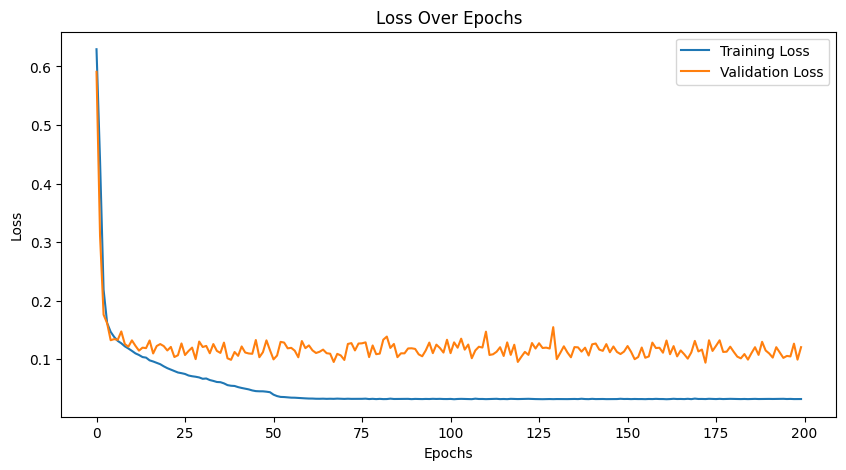

In [39]:
# Model Parameters
input_embed_size = 1024  # Original input embedding size
transformer_embed_size = 128  # Reduced embedding size for transformer
num_heads = 128  # Adjusted to fit the reduced embedding size
num_layers = 1
output_size = 1024  # Output size to match the original embedding size
dropout_rate = 0.1

# Model
model = CustomTransformer(input_embed_size, transformer_embed_size, num_heads, num_layers, output_size, dropout_rate).to(device)
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

epochs = 200


validator = Validator(model, valid_loader, device)

train_losses, valid_losses, test_loss = train_model(model, train_loader, valid_loader, test_loader, optimizer, epochs, device)
plot_losses(train_losses, valid_losses)

## GGG

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class CustomModel(nn.Module):
    def __init__(self, input_embed_size, gru_embed_size, output_size, dropout_rate=0.1):
        super(CustomModel, self).__init__()
        
        # GRU for dimensionality reduction: input_embed_size -> gru_embed_size
        self.gru_down1 = nn.GRU(input_size=input_embed_size, hidden_size=512, batch_first=True)
        self.batchnorm_down1 = nn.BatchNorm1d(num_features=512)
        self.gru_down2 = nn.GRU(input_size=512, hidden_size=256, batch_first=True)
        self.batchnorm_down2 = nn.BatchNorm1d(num_features=256)
        self.gru_down3 = nn.GRU(input_size=256, hidden_size=gru_embed_size, batch_first=True)
        self.batchnorm_down3 = nn.BatchNorm1d(num_features=gru_embed_size)
        
        # Replacing Transformer layers with a GRU layer followed by batch norm layer
        self.gru_middle = nn.GRU(input_size=gru_embed_size, hidden_size=gru_embed_size, batch_first=True)
        self.batchnorm_middle = nn.BatchNorm1d(num_features=gru_embed_size)
        
        # Linear layer after GRU
        self.fc_middle = nn.Linear(gru_embed_size, gru_embed_size)
        
        # GRU for dimensionality increasing: gru_embed_size -> output_size
        self.gru_up1 = nn.GRU(input_size=gru_embed_size, hidden_size=256, batch_first=True)
        self.batchnorm_up1 = nn.BatchNorm1d(num_features=256)
        self.gru_up2 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.batchnorm_up2 = nn.BatchNorm1d(num_features=512)
        self.gru_up3 = nn.GRU(input_size=512, hidden_size=output_size, batch_first=True)
        self.batchnorm_up3 = nn.BatchNorm1d(num_features=output_size)
        
        # Final output layer
        self.fc_out = nn.Linear(output_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Ensure x is 3D (batch_size, seq_len, input_embed_size)
        if x.dim() == 2:
            x = x.unsqueeze(1)
    
        # GRU down
        x, _ = self.gru_down1(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_down1(x)
        x = x.transpose(1, 2)
        
        x, _ = self.gru_down2(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_down2(x)
        x = x.transpose(1, 2)
        
        x, _ = self.gru_down3(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_down3(x)
        x = x.transpose(1, 2)
        
        # Middle GRU and BatchNorm
        x, _ = self.gru_middle(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_middle(x)
        x = x.transpose(1, 2)
        
        #x, _ = self.gru_middle(x)
        #x = x.transpose(1, 2)
        #x = self.batchnorm_middle(x)
        #x = x.transpose(1, 2)

        
        # Linear layer
        x = self.fc_middle(x)
        
        # GRU up
        x, _ = self.gru_up1(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_up1(x)
        x = x.transpose(1, 2)
        
        x, _ = self.gru_up2(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_up2(x)
        x = x.transpose(1, 2)
        
        x, _ = self.gru_up3(x)
        x = x.transpose(1, 2)
        x = self.batchnorm_up3(x)
        x = x.transpose(1, 2)
        
        # Final output
        x = x.reshape(x.shape[0], -1)  # Flatten
        x = self.fc_out(x)
        
        return torch.sigmoid(x)


class TanimotoLoss(nn.Module):
    def __init__(self):
        super(TanimotoLoss, self).__init__()

    def forward(self, predictions, targets):
        # Ensuring the predictions and targets are of type float
        predictions = predictions.float()
        targets = targets.float()

        # Calculate the Tanimoto similarity
        intersection = torch.sum(predictions * targets, dim=1)
        union = torch.sum(predictions, dim=1) + torch.sum(targets, dim=1) - intersection
        tanimoto_similarity = intersection / union

        # The Tanimoto loss is 1 minus the similarity
        tanimoto_loss = 1 - tanimoto_similarity

        # Return the mean Tanimoto loss
        return torch.mean(tanimoto_loss)
loss_function=nn.BCELoss()
def train_model(model, train_loader, valid_loader, test_loader, optimizer, epochs, device):
    train_losses, valid_losses = [], []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch['description_emb'].to(device), batch['fingerprint'].to(device)

            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss: {loss.item()}')

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        valid_loss = validator.validate()
        valid_losses.append(valid_loss)
            # Scheduler step
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {valid_loss}')
    test_loss = test_model(model, test_loader, device)

    return train_losses, valid_losses,test_loss



# Validation Class
class Validator:
    def __init__(self, model, data_loader, device):
        self.model = model
        self.data_loader = data_loader
        self.device = device

    def validate(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in self.data_loader:
                inputs, targets = batch['description_emb'].to(self.device), batch['fingerprint'].to(self.device)
                predictions = self.model(inputs)
                loss = loss_function(predictions, targets)
                total_loss += loss.item()
        avg_loss = total_loss / len(self.data_loader)
        return avg_loss

def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['description_emb'].to(device), batch['fingerprint'].to(device)
            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss}')
    return avg_loss

def save_checkpoint(state, filename="model_checkpoint_GRU.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

Epoch 1, Batch 1, Batch Loss: 0.7323290109634399
Epoch 1, Batch 2, Batch Loss: 0.7060679197311401
Epoch 1, Batch 3, Batch Loss: 0.6872344613075256
Epoch 1, Batch 4, Batch Loss: 0.676181435585022
Epoch 1, Batch 5, Batch Loss: 0.6655377149581909
Epoch 1, Batch 6, Batch Loss: 0.6654918789863586
Epoch 1, Batch 7, Batch Loss: 0.6562035083770752
Epoch 1, Batch 8, Batch Loss: 0.6467897891998291
Epoch 1, Batch 9, Batch Loss: 0.6481837630271912
Epoch 1, Batch 10, Batch Loss: 0.641633152961731
Epoch 1, Batch 11, Batch Loss: 0.636856734752655
Epoch 1, Batch 12, Batch Loss: 0.632976770401001
Epoch 1, Batch 13, Batch Loss: 0.6219476461410522
Epoch 1, Batch 14, Batch Loss: 0.6149100065231323
Epoch 1, Batch 15, Batch Loss: 0.6136815547943115
Epoch 1, Batch 16, Batch Loss: 0.6061077117919922
Epoch 1, Batch 17, Batch Loss: 0.6008902788162231
Epoch 1, Batch 18, Batch Loss: 0.5876609086990356
Epoch 1, Batch 19, Batch Loss: 0.5936951637268066
Epoch 1, Batch 20, Batch Loss: 0.5866506695747375
Epoch 1, Batc

Epoch 7, Batch 3, Batch Loss: 0.12088312208652496
Epoch 7, Batch 4, Batch Loss: 0.12847846746444702
Epoch 7, Batch 5, Batch Loss: 0.1212729886174202
Epoch 7, Batch 6, Batch Loss: 0.12770318984985352
Epoch 7, Batch 7, Batch Loss: 0.1225653886795044
Epoch 7, Batch 8, Batch Loss: 0.12089826911687851
Epoch 7, Batch 9, Batch Loss: 0.12403688579797745
Epoch 7, Batch 10, Batch Loss: 0.12571942806243896
Epoch 7, Batch 11, Batch Loss: 0.12288147211074829
Epoch 7, Batch 12, Batch Loss: 0.1177273839712143
Epoch 7, Batch 13, Batch Loss: 0.1189541146159172
Epoch 7, Batch 14, Batch Loss: 0.12180756777524948
Epoch 7, Batch 15, Batch Loss: 0.11677944660186768
Epoch 7, Batch 16, Batch Loss: 0.1190871149301529
Epoch 7, Batch 17, Batch Loss: 0.124628946185112
Epoch 7, Batch 18, Batch Loss: 0.12274454534053802
Epoch 7, Batch 19, Batch Loss: 0.12261452525854111
Epoch 7, Batch 20, Batch Loss: 0.11652742326259613
Epoch 7, Batch 21, Batch Loss: 0.11655252426862717
Epoch 7, Batch 22, Batch Loss: 0.117730133235

Epoch 13, Batch 4, Batch Loss: 0.10053014755249023
Epoch 13, Batch 5, Batch Loss: 0.10822568088769913
Epoch 13, Batch 6, Batch Loss: 0.09890101850032806
Epoch 13, Batch 7, Batch Loss: 0.09885852038860321
Epoch 13, Batch 8, Batch Loss: 0.09522788226604462
Epoch 13, Batch 9, Batch Loss: 0.0979716032743454
Epoch 13, Batch 10, Batch Loss: 0.09479532390832901
Epoch 13, Batch 11, Batch Loss: 0.10053946822881699
Epoch 13, Batch 12, Batch Loss: 0.09531061351299286
Epoch 13, Batch 13, Batch Loss: 0.09475907683372498
Epoch 13, Batch 14, Batch Loss: 0.1015063002705574
Epoch 13, Batch 15, Batch Loss: 0.10267588496208191
Epoch 13, Batch 16, Batch Loss: 0.09681639075279236
Epoch 13, Batch 17, Batch Loss: 0.09643910080194473
Epoch 13, Batch 18, Batch Loss: 0.10292157530784607
Epoch 13, Batch 19, Batch Loss: 0.09939230978488922
Epoch 13, Batch 20, Batch Loss: 0.09693332016468048
Epoch 13, Batch 21, Batch Loss: 0.09238679707050323
Epoch 13, Batch 22, Batch Loss: 0.09976759552955627
Epoch 13, Batch 23, 

Epoch 19, Batch 4, Batch Loss: 0.0816531702876091
Epoch 19, Batch 5, Batch Loss: 0.08389928191900253
Epoch 19, Batch 6, Batch Loss: 0.07890383899211884
Epoch 19, Batch 7, Batch Loss: 0.09040451049804688
Epoch 19, Batch 8, Batch Loss: 0.09144149720668793
Epoch 19, Batch 9, Batch Loss: 0.08323140442371368
Epoch 19, Batch 10, Batch Loss: 0.08019367605447769
Epoch 19, Batch 11, Batch Loss: 0.08649551868438721
Epoch 19, Batch 12, Batch Loss: 0.08364520967006683
Epoch 19, Batch 13, Batch Loss: 0.08427987992763519
Epoch 19, Batch 14, Batch Loss: 0.08822329342365265
Epoch 19, Batch 15, Batch Loss: 0.07655911147594452
Epoch 19, Batch 16, Batch Loss: 0.08589856326580048
Epoch 19, Batch 17, Batch Loss: 0.08140826225280762
Epoch 19, Batch 18, Batch Loss: 0.08187297731637955
Epoch 19, Batch 19, Batch Loss: 0.0844515711069107
Epoch 19, Batch 20, Batch Loss: 0.08228789269924164
Epoch 19, Batch 21, Batch Loss: 0.0871237963438034
Epoch 19, Batch 22, Batch Loss: 0.08260747790336609
Epoch 19, Batch 23, B

Epoch 25, Batch 4, Batch Loss: 0.06807228922843933
Epoch 25, Batch 5, Batch Loss: 0.07019592076539993
Epoch 25, Batch 6, Batch Loss: 0.06910152733325958
Epoch 25, Batch 7, Batch Loss: 0.06644529104232788
Epoch 25, Batch 8, Batch Loss: 0.07492542266845703
Epoch 25, Batch 9, Batch Loss: 0.06911203265190125
Epoch 25, Batch 10, Batch Loss: 0.06868980079889297
Epoch 25, Batch 11, Batch Loss: 0.067436583340168
Epoch 25, Batch 12, Batch Loss: 0.06555220484733582
Epoch 25, Batch 13, Batch Loss: 0.0670289695262909
Epoch 25, Batch 14, Batch Loss: 0.06316128373146057
Epoch 25, Batch 15, Batch Loss: 0.06875546276569366
Epoch 25, Batch 16, Batch Loss: 0.06706264615058899
Epoch 25, Batch 17, Batch Loss: 0.06782019138336182
Epoch 25, Batch 18, Batch Loss: 0.06803570687770844
Epoch 25, Batch 19, Batch Loss: 0.06359526515007019
Epoch 25, Batch 20, Batch Loss: 0.06522169709205627
Epoch 25, Batch 21, Batch Loss: 0.06411869823932648
Epoch 25, Batch 22, Batch Loss: 0.06841413676738739
Epoch 25, Batch 23, B

Epoch 31, Batch 3, Batch Loss: 0.056142326444387436
Epoch 31, Batch 4, Batch Loss: 0.05799559876322746
Epoch 31, Batch 5, Batch Loss: 0.06048082560300827
Epoch 31, Batch 6, Batch Loss: 0.06014519929885864
Epoch 31, Batch 7, Batch Loss: 0.05622361972928047
Epoch 31, Batch 8, Batch Loss: 0.06232880800962448
Epoch 31, Batch 9, Batch Loss: 0.060196686536073685
Epoch 31, Batch 10, Batch Loss: 0.05980229377746582
Epoch 31, Batch 11, Batch Loss: 0.05579198896884918
Epoch 31, Batch 12, Batch Loss: 0.06255719810724258
Epoch 31, Batch 13, Batch Loss: 0.05981001257896423
Epoch 31, Batch 14, Batch Loss: 0.062278807163238525
Epoch 31, Batch 15, Batch Loss: 0.06255006790161133
Epoch 31, Batch 16, Batch Loss: 0.06175268813967705
Epoch 31, Batch 17, Batch Loss: 0.055459991097450256
Epoch 31, Batch 18, Batch Loss: 0.05619257315993309
Epoch 31, Batch 19, Batch Loss: 0.06231940537691116
Epoch 31, Batch 20, Batch Loss: 0.06250935792922974
Epoch 31, Batch 21, Batch Loss: 0.05735810846090317
Epoch 31, Batch

Epoch 37, Batch 1, Batch Loss: 0.054769597947597504
Epoch 37, Batch 2, Batch Loss: 0.04855713993310928
Epoch 37, Batch 3, Batch Loss: 0.049005862325429916
Epoch 37, Batch 4, Batch Loss: 0.04648325592279434
Epoch 37, Batch 5, Batch Loss: 0.05184406042098999
Epoch 37, Batch 6, Batch Loss: 0.04970070347189903
Epoch 37, Batch 7, Batch Loss: 0.049074701964855194
Epoch 37, Batch 8, Batch Loss: 0.05389750003814697
Epoch 37, Batch 9, Batch Loss: 0.05230522155761719
Epoch 37, Batch 10, Batch Loss: 0.04730970412492752
Epoch 37, Batch 11, Batch Loss: 0.04864753782749176
Epoch 37, Batch 12, Batch Loss: 0.045823127031326294
Epoch 37, Batch 13, Batch Loss: 0.04675254970788956
Epoch 37, Batch 14, Batch Loss: 0.04425566643476486
Epoch 37, Batch 15, Batch Loss: 0.047102347016334534
Epoch 37, Batch 16, Batch Loss: 0.04894382506608963
Epoch 37, Batch 17, Batch Loss: 0.052850037813186646
Epoch 37, Batch 18, Batch Loss: 0.050078023225069046
Epoch 37, Batch 19, Batch Loss: 0.04938564449548721
Epoch 37, Batc

Epoch 42, Train Loss: 0.04340572506189346, Validation Loss: 0.10766136646270752
Epoch 43, Batch 1, Batch Loss: 0.04333248361945152
Epoch 43, Batch 2, Batch Loss: 0.04155544936656952
Epoch 43, Batch 3, Batch Loss: 0.04125324636697769
Epoch 43, Batch 4, Batch Loss: 0.04037323221564293
Epoch 43, Batch 5, Batch Loss: 0.04433415085077286
Epoch 43, Batch 6, Batch Loss: 0.04351544752717018
Epoch 43, Batch 7, Batch Loss: 0.04041314870119095
Epoch 43, Batch 8, Batch Loss: 0.04094592481851578
Epoch 43, Batch 9, Batch Loss: 0.0425284281373024
Epoch 43, Batch 10, Batch Loss: 0.04521831497550011
Epoch 43, Batch 11, Batch Loss: 0.04348020628094673
Epoch 43, Batch 12, Batch Loss: 0.04233742505311966
Epoch 43, Batch 13, Batch Loss: 0.04163021966814995
Epoch 43, Batch 14, Batch Loss: 0.043646834790706635
Epoch 43, Batch 15, Batch Loss: 0.04178386181592941
Epoch 43, Batch 16, Batch Loss: 0.04364557936787605
Epoch 43, Batch 17, Batch Loss: 0.04174944385886192
Epoch 43, Batch 18, Batch Loss: 0.04280985891

Epoch 48, Batch 25, Batch Loss: 0.04451847821474075
=> Saving checkpoint
Epoch 48, Train Loss: 0.04142639309167862, Validation Loss: 0.09416336100548506
Epoch 49, Batch 1, Batch Loss: 0.03971529006958008
Epoch 49, Batch 2, Batch Loss: 0.0384274385869503
Epoch 49, Batch 3, Batch Loss: 0.041068628430366516
Epoch 49, Batch 4, Batch Loss: 0.039774272590875626
Epoch 49, Batch 5, Batch Loss: 0.04171397164463997
Epoch 49, Batch 6, Batch Loss: 0.043959930539131165
Epoch 49, Batch 7, Batch Loss: 0.0426936000585556
Epoch 49, Batch 8, Batch Loss: 0.03612014278769493
Epoch 49, Batch 9, Batch Loss: 0.045635972172021866
Epoch 49, Batch 10, Batch Loss: 0.04113120585680008
Epoch 49, Batch 11, Batch Loss: 0.041442278772592545
Epoch 49, Batch 12, Batch Loss: 0.040339209139347076
Epoch 49, Batch 13, Batch Loss: 0.044610846787691116
Epoch 49, Batch 14, Batch Loss: 0.04380250722169876
Epoch 49, Batch 15, Batch Loss: 0.04193384200334549
Epoch 49, Batch 16, Batch Loss: 0.0398201048374176
Epoch 49, Batch 17, 

Epoch 54, Batch 24, Batch Loss: 0.04533293843269348
Epoch 54, Batch 25, Batch Loss: 0.049178265035152435
Epoch 54, Train Loss: 0.040210407227277756, Validation Loss: 0.11655009351670742
Epoch 55, Batch 1, Batch Loss: 0.03850419074296951
Epoch 55, Batch 2, Batch Loss: 0.03855274245142937
Epoch 55, Batch 3, Batch Loss: 0.03803083300590515
Epoch 55, Batch 4, Batch Loss: 0.0409221388399601
Epoch 55, Batch 5, Batch Loss: 0.0393119752407074
Epoch 55, Batch 6, Batch Loss: 0.03904496133327484
Epoch 55, Batch 7, Batch Loss: 0.039381325244903564
Epoch 55, Batch 8, Batch Loss: 0.040625691413879395
Epoch 55, Batch 9, Batch Loss: 0.04152471572160721
Epoch 55, Batch 10, Batch Loss: 0.03874366730451584
Epoch 55, Batch 11, Batch Loss: 0.03760647773742676
Epoch 55, Batch 12, Batch Loss: 0.04008374363183975
Epoch 55, Batch 13, Batch Loss: 0.03955361619591713
Epoch 55, Batch 14, Batch Loss: 0.04062476009130478
Epoch 55, Batch 15, Batch Loss: 0.03959159553050995
Epoch 55, Batch 16, Batch Loss: 0.041607100

Epoch 60, Batch 22, Batch Loss: 0.03852011263370514
Epoch 60, Batch 23, Batch Loss: 0.03735101595520973
Epoch 60, Batch 24, Batch Loss: 0.038537852466106415
Epoch 60, Batch 25, Batch Loss: 0.05017399415373802
Epoch 60, Train Loss: 0.03885237157344818, Validation Loss: 0.13768665678799152
Epoch 61, Batch 1, Batch Loss: 0.03838499262928963
Epoch 61, Batch 2, Batch Loss: 0.03605293482542038
Epoch 61, Batch 3, Batch Loss: 0.03844805061817169
Epoch 61, Batch 4, Batch Loss: 0.040192268788814545
Epoch 61, Batch 5, Batch Loss: 0.0367378368973732
Epoch 61, Batch 6, Batch Loss: 0.03653789311647415
Epoch 61, Batch 7, Batch Loss: 0.0381932258605957
Epoch 61, Batch 8, Batch Loss: 0.0362994484603405
Epoch 61, Batch 9, Batch Loss: 0.038791269063949585
Epoch 61, Batch 10, Batch Loss: 0.03838781267404556
Epoch 61, Batch 11, Batch Loss: 0.04156346619129181
Epoch 61, Batch 12, Batch Loss: 0.037965282797813416
Epoch 61, Batch 13, Batch Loss: 0.04077469930052757
Epoch 61, Batch 14, Batch Loss: 0.0370625331

Epoch 66, Batch 21, Batch Loss: 0.036710649728775024
Epoch 66, Batch 22, Batch Loss: 0.03949744999408722
Epoch 66, Batch 23, Batch Loss: 0.03829493373632431
Epoch 66, Batch 24, Batch Loss: 0.038775622844696045
Epoch 66, Batch 25, Batch Loss: 0.045177213847637177
Epoch 66, Train Loss: 0.03832960471510887, Validation Loss: 0.12493358179926872
Epoch 67, Batch 1, Batch Loss: 0.03888805955648422
Epoch 67, Batch 2, Batch Loss: 0.04019477963447571
Epoch 67, Batch 3, Batch Loss: 0.041884634643793106
Epoch 67, Batch 4, Batch Loss: 0.0391559861600399
Epoch 67, Batch 5, Batch Loss: 0.0404878631234169
Epoch 67, Batch 6, Batch Loss: 0.039196211844682693
Epoch 67, Batch 7, Batch Loss: 0.03917648643255234
Epoch 67, Batch 8, Batch Loss: 0.03696543723344803
Epoch 67, Batch 9, Batch Loss: 0.03848569840192795
Epoch 67, Batch 10, Batch Loss: 0.03749006241559982
Epoch 67, Batch 11, Batch Loss: 0.03481246903538704
Epoch 67, Batch 12, Batch Loss: 0.03948868066072464
Epoch 67, Batch 13, Batch Loss: 0.04008679

Epoch 72, Batch 19, Batch Loss: 0.03876643255352974
Epoch 72, Batch 20, Batch Loss: 0.03874824941158295
Epoch 72, Batch 21, Batch Loss: 0.03406889736652374
Epoch 72, Batch 22, Batch Loss: 0.040101345628499985
Epoch 72, Batch 23, Batch Loss: 0.038726840168237686
Epoch 72, Batch 24, Batch Loss: 0.036753296852111816
Epoch 72, Batch 25, Batch Loss: 0.049338437616825104
Epoch 72, Train Loss: 0.03838113754987717, Validation Loss: 0.10660110786557198
Epoch 73, Batch 1, Batch Loss: 0.036672692745923996
Epoch 73, Batch 2, Batch Loss: 0.03631981462240219
Epoch 73, Batch 3, Batch Loss: 0.03842742741107941
Epoch 73, Batch 4, Batch Loss: 0.03626088798046112
Epoch 73, Batch 5, Batch Loss: 0.041091687977313995
Epoch 73, Batch 6, Batch Loss: 0.03619195893406868
Epoch 73, Batch 7, Batch Loss: 0.03591255471110344
Epoch 73, Batch 8, Batch Loss: 0.03474682569503784
Epoch 73, Batch 9, Batch Loss: 0.03653045743703842
Epoch 73, Batch 10, Batch Loss: 0.037059761583805084
Epoch 73, Batch 11, Batch Loss: 0.0402

Epoch 78, Batch 18, Batch Loss: 0.03780791535973549
Epoch 78, Batch 19, Batch Loss: 0.03804367035627365
Epoch 78, Batch 20, Batch Loss: 0.03834892064332962
Epoch 78, Batch 21, Batch Loss: 0.03750244528055191
Epoch 78, Batch 22, Batch Loss: 0.035675015300512314
Epoch 78, Batch 23, Batch Loss: 0.03792904317378998
Epoch 78, Batch 24, Batch Loss: 0.03934229537844658
Epoch 78, Batch 25, Batch Loss: 0.03786863759160042
Epoch 78, Train Loss: 0.037944997847080233, Validation Loss: 0.10747829638421535
Epoch 79, Batch 1, Batch Loss: 0.03817961737513542
Epoch 79, Batch 2, Batch Loss: 0.038031186908483505
Epoch 79, Batch 3, Batch Loss: 0.03788378834724426
Epoch 79, Batch 4, Batch Loss: 0.03613597899675369
Epoch 79, Batch 5, Batch Loss: 0.03717861324548721
Epoch 79, Batch 6, Batch Loss: 0.04011227935552597
Epoch 79, Batch 7, Batch Loss: 0.03603420779109001
Epoch 79, Batch 8, Batch Loss: 0.040210068225860596
Epoch 79, Batch 9, Batch Loss: 0.03867040574550629
Epoch 79, Batch 10, Batch Loss: 0.0381763

Epoch 84, Batch 16, Batch Loss: 0.0389663465321064
Epoch 84, Batch 17, Batch Loss: 0.03786364197731018
Epoch 84, Batch 18, Batch Loss: 0.037462636828422546
Epoch 84, Batch 19, Batch Loss: 0.036469727754592896
Epoch 84, Batch 20, Batch Loss: 0.040185727179050446
Epoch 84, Batch 21, Batch Loss: 0.03992432728409767
Epoch 84, Batch 22, Batch Loss: 0.037321679294109344
Epoch 84, Batch 23, Batch Loss: 0.03856721147894859
Epoch 84, Batch 24, Batch Loss: 0.03813832253217697
Epoch 84, Batch 25, Batch Loss: 0.057640980929136276
Epoch 84, Train Loss: 0.03863284140825272, Validation Loss: 0.12940793111920357
Epoch 85, Batch 1, Batch Loss: 0.037895843386650085
Epoch 85, Batch 2, Batch Loss: 0.03500093147158623
Epoch 85, Batch 3, Batch Loss: 0.03944969177246094
Epoch 85, Batch 4, Batch Loss: 0.03497249633073807
Epoch 85, Batch 5, Batch Loss: 0.03462419658899307
Epoch 85, Batch 6, Batch Loss: 0.03843827545642853
Epoch 85, Batch 7, Batch Loss: 0.04021143168210983
Epoch 85, Batch 8, Batch Loss: 0.03509

Epoch 90, Batch 15, Batch Loss: 0.04160512611269951
Epoch 90, Batch 16, Batch Loss: 0.03547579422593117
Epoch 90, Batch 17, Batch Loss: 0.035416021943092346
Epoch 90, Batch 18, Batch Loss: 0.038316670805215836
Epoch 90, Batch 19, Batch Loss: 0.0375661626458168
Epoch 90, Batch 20, Batch Loss: 0.03785890340805054
Epoch 90, Batch 21, Batch Loss: 0.04160872474312782
Epoch 90, Batch 22, Batch Loss: 0.036225177347660065
Epoch 90, Batch 23, Batch Loss: 0.03683847188949585
Epoch 90, Batch 24, Batch Loss: 0.03835558146238327
Epoch 90, Batch 25, Batch Loss: 0.03986340016126633
Epoch 90, Train Loss: 0.038037984669208526, Validation Loss: 0.11183204129338264
Epoch 91, Batch 1, Batch Loss: 0.036730118095874786
Epoch 91, Batch 2, Batch Loss: 0.035482652485370636
Epoch 91, Batch 3, Batch Loss: 0.0341046005487442
Epoch 91, Batch 4, Batch Loss: 0.036450378596782684
Epoch 91, Batch 5, Batch Loss: 0.04075619950890541
Epoch 91, Batch 6, Batch Loss: 0.038279540836811066
Epoch 91, Batch 7, Batch Loss: 0.037

Epoch 96, Batch 13, Batch Loss: 0.03685515373945236
Epoch 96, Batch 14, Batch Loss: 0.038119904696941376
Epoch 96, Batch 15, Batch Loss: 0.03941075876355171
Epoch 96, Batch 16, Batch Loss: 0.0377141572535038
Epoch 96, Batch 17, Batch Loss: 0.03580569848418236
Epoch 96, Batch 18, Batch Loss: 0.03655771166086197
Epoch 96, Batch 19, Batch Loss: 0.03375560790300369
Epoch 96, Batch 20, Batch Loss: 0.036931052803993225
Epoch 96, Batch 21, Batch Loss: 0.039082493633031845
Epoch 96, Batch 22, Batch Loss: 0.03932679444551468
Epoch 96, Batch 23, Batch Loss: 0.03601337969303131
Epoch 96, Batch 24, Batch Loss: 0.03777451068162918
Epoch 96, Batch 25, Batch Loss: 0.03626089543104172
Epoch 96, Train Loss: 0.037891961187124255, Validation Loss: 0.122204614803195
Epoch 97, Batch 1, Batch Loss: 0.0398622527718544
Epoch 97, Batch 2, Batch Loss: 0.036783743649721146
Epoch 97, Batch 3, Batch Loss: 0.035257402807474136
Epoch 97, Batch 4, Batch Loss: 0.03742564469575882
Epoch 97, Batch 5, Batch Loss: 0.04059

Epoch 102, Batch 11, Batch Loss: 0.0397135391831398
Epoch 102, Batch 12, Batch Loss: 0.03998024761676788
Epoch 102, Batch 13, Batch Loss: 0.038744136691093445
Epoch 102, Batch 14, Batch Loss: 0.0399324968457222
Epoch 102, Batch 15, Batch Loss: 0.03977208584547043
Epoch 102, Batch 16, Batch Loss: 0.037116944789886475
Epoch 102, Batch 17, Batch Loss: 0.03674747794866562
Epoch 102, Batch 18, Batch Loss: 0.03512001410126686
Epoch 102, Batch 19, Batch Loss: 0.036338530480861664
Epoch 102, Batch 20, Batch Loss: 0.035252489149570465
Epoch 102, Batch 21, Batch Loss: 0.04045533388853073
Epoch 102, Batch 22, Batch Loss: 0.03565269336104393
Epoch 102, Batch 23, Batch Loss: 0.03752102702856064
Epoch 102, Batch 24, Batch Loss: 0.039979174733161926
Epoch 102, Batch 25, Batch Loss: 0.03959841653704643
Epoch 102, Train Loss: 0.03801443815231323, Validation Loss: 0.12128563784062862
Epoch 103, Batch 1, Batch Loss: 0.036988019943237305
Epoch 103, Batch 2, Batch Loss: 0.036753080785274506
Epoch 103, Batc

Epoch 108, Batch 7, Batch Loss: 0.03807394951581955
Epoch 108, Batch 8, Batch Loss: 0.036074139177799225
Epoch 108, Batch 9, Batch Loss: 0.03790532052516937
Epoch 108, Batch 10, Batch Loss: 0.036184366792440414
Epoch 108, Batch 11, Batch Loss: 0.0369870588183403
Epoch 108, Batch 12, Batch Loss: 0.03958510234951973
Epoch 108, Batch 13, Batch Loss: 0.03750064969062805
Epoch 108, Batch 14, Batch Loss: 0.038071244955062866
Epoch 108, Batch 15, Batch Loss: 0.03641785681247711
Epoch 108, Batch 16, Batch Loss: 0.037597328424453735
Epoch 108, Batch 17, Batch Loss: 0.0378011018037796
Epoch 108, Batch 18, Batch Loss: 0.03907788544893265
Epoch 108, Batch 19, Batch Loss: 0.03616812825202942
Epoch 108, Batch 20, Batch Loss: 0.03720589727163315
Epoch 108, Batch 21, Batch Loss: 0.04122413694858551
Epoch 108, Batch 22, Batch Loss: 0.036572523415088654
Epoch 108, Batch 23, Batch Loss: 0.041126057505607605
Epoch 108, Batch 24, Batch Loss: 0.03937883675098419
Epoch 108, Batch 25, Batch Loss: 0.0446212030

Epoch 114, Batch 3, Batch Loss: 0.03768307715654373
Epoch 114, Batch 4, Batch Loss: 0.03605417162179947
Epoch 114, Batch 5, Batch Loss: 0.03653055429458618
Epoch 114, Batch 6, Batch Loss: 0.038080714643001556
Epoch 114, Batch 7, Batch Loss: 0.04108208417892456
Epoch 114, Batch 8, Batch Loss: 0.039840079843997955
Epoch 114, Batch 9, Batch Loss: 0.03734615445137024
Epoch 114, Batch 10, Batch Loss: 0.039889149367809296
Epoch 114, Batch 11, Batch Loss: 0.038195736706256866
Epoch 114, Batch 12, Batch Loss: 0.03665671497583389
Epoch 114, Batch 13, Batch Loss: 0.03750471770763397
Epoch 114, Batch 14, Batch Loss: 0.03643472120165825
Epoch 114, Batch 15, Batch Loss: 0.042394861578941345
Epoch 114, Batch 16, Batch Loss: 0.03504069894552231
Epoch 114, Batch 17, Batch Loss: 0.03981835022568703
Epoch 114, Batch 18, Batch Loss: 0.03748559206724167
Epoch 114, Batch 19, Batch Loss: 0.038860417902469635
Epoch 114, Batch 20, Batch Loss: 0.03842460364103317
Epoch 114, Batch 21, Batch Loss: 0.036533348262

Epoch 119, Train Loss: 0.03789982065558434, Validation Loss: 0.11971975304186344
Epoch 120, Batch 1, Batch Loss: 0.03873074799776077
Epoch 120, Batch 2, Batch Loss: 0.03632795065641403
Epoch 120, Batch 3, Batch Loss: 0.036359935998916626
Epoch 120, Batch 4, Batch Loss: 0.04294412583112717
Epoch 120, Batch 5, Batch Loss: 0.038424693048000336
Epoch 120, Batch 6, Batch Loss: 0.03587573021650314
Epoch 120, Batch 7, Batch Loss: 0.03622173145413399
Epoch 120, Batch 8, Batch Loss: 0.03947470337152481
Epoch 120, Batch 9, Batch Loss: 0.039473630487918854
Epoch 120, Batch 10, Batch Loss: 0.0378684476017952
Epoch 120, Batch 11, Batch Loss: 0.03740501403808594
Epoch 120, Batch 12, Batch Loss: 0.038630709052085876
Epoch 120, Batch 13, Batch Loss: 0.0411616750061512
Epoch 120, Batch 14, Batch Loss: 0.03708384931087494
Epoch 120, Batch 15, Batch Loss: 0.037025921046733856
Epoch 120, Batch 16, Batch Loss: 0.03748716786503792
Epoch 120, Batch 17, Batch Loss: 0.034840043634176254
Epoch 120, Batch 18, Ba

Epoch 125, Batch 22, Batch Loss: 0.039084017276763916
Epoch 125, Batch 23, Batch Loss: 0.037200845777988434
Epoch 125, Batch 24, Batch Loss: 0.03717027232050896
Epoch 125, Batch 25, Batch Loss: 0.04708454757928848
Epoch 125, Train Loss: 0.03828790798783302, Validation Loss: 0.12198223546147346
Epoch 126, Batch 1, Batch Loss: 0.037533052265644073
Epoch 126, Batch 2, Batch Loss: 0.036489397287368774
Epoch 126, Batch 3, Batch Loss: 0.03790723532438278
Epoch 126, Batch 4, Batch Loss: 0.035638898611068726
Epoch 126, Batch 5, Batch Loss: 0.03970157355070114
Epoch 126, Batch 6, Batch Loss: 0.04016412794589996
Epoch 126, Batch 7, Batch Loss: 0.03565496206283569
Epoch 126, Batch 8, Batch Loss: 0.03921699896454811
Epoch 126, Batch 9, Batch Loss: 0.04037651792168617
Epoch 126, Batch 10, Batch Loss: 0.03801964595913887
Epoch 126, Batch 11, Batch Loss: 0.037972498685121536
Epoch 126, Batch 12, Batch Loss: 0.03780316188931465
Epoch 126, Batch 13, Batch Loss: 0.03969629853963852
Epoch 126, Batch 14, 

Epoch 131, Batch 18, Batch Loss: 0.03583942726254463
Epoch 131, Batch 19, Batch Loss: 0.0377805158495903
Epoch 131, Batch 20, Batch Loss: 0.03829169273376465
Epoch 131, Batch 21, Batch Loss: 0.038778118789196014
Epoch 131, Batch 22, Batch Loss: 0.03795860707759857
Epoch 131, Batch 23, Batch Loss: 0.03834119066596031
Epoch 131, Batch 24, Batch Loss: 0.038926757872104645
Epoch 131, Batch 25, Batch Loss: 0.03839939087629318
Epoch 131, Train Loss: 0.03795227974653244, Validation Loss: 0.1166410930454731
Epoch 132, Batch 1, Batch Loss: 0.03999463468790054
Epoch 132, Batch 2, Batch Loss: 0.03938600420951843
Epoch 132, Batch 3, Batch Loss: 0.03912171721458435
Epoch 132, Batch 4, Batch Loss: 0.036244384944438934
Epoch 132, Batch 5, Batch Loss: 0.03655892610549927
Epoch 132, Batch 6, Batch Loss: 0.040268704295158386
Epoch 132, Batch 7, Batch Loss: 0.03594832867383957
Epoch 132, Batch 8, Batch Loss: 0.03648897260427475
Epoch 132, Batch 9, Batch Loss: 0.03686045855283737
Epoch 132, Batch 10, Batc

Epoch 137, Batch 15, Batch Loss: 0.03709184378385544
Epoch 137, Batch 16, Batch Loss: 0.0379495769739151
Epoch 137, Batch 17, Batch Loss: 0.03713074326515198
Epoch 137, Batch 18, Batch Loss: 0.03843525052070618
Epoch 137, Batch 19, Batch Loss: 0.035162173211574554
Epoch 137, Batch 20, Batch Loss: 0.034447863698005676
Epoch 137, Batch 21, Batch Loss: 0.04061376303434372
Epoch 137, Batch 22, Batch Loss: 0.03860829770565033
Epoch 137, Batch 23, Batch Loss: 0.03738607093691826
Epoch 137, Batch 24, Batch Loss: 0.038142118602991104
Epoch 137, Batch 25, Batch Loss: 0.03446526825428009
Epoch 137, Train Loss: 0.03773159235715866, Validation Loss: 0.1166454404592514
Epoch 138, Batch 1, Batch Loss: 0.03685697540640831
Epoch 138, Batch 2, Batch Loss: 0.037588801234960556
Epoch 138, Batch 3, Batch Loss: 0.038701221346855164
Epoch 138, Batch 4, Batch Loss: 0.03782165050506592
Epoch 138, Batch 5, Batch Loss: 0.04196222126483917
Epoch 138, Batch 6, Batch Loss: 0.03918587416410446
Epoch 138, Batch 7, B

Epoch 143, Batch 11, Batch Loss: 0.040302734822034836
Epoch 143, Batch 12, Batch Loss: 0.035140179097652435
Epoch 143, Batch 13, Batch Loss: 0.03766555339097977
Epoch 143, Batch 14, Batch Loss: 0.039562009274959564
Epoch 143, Batch 15, Batch Loss: 0.040599677711725235
Epoch 143, Batch 16, Batch Loss: 0.03755677118897438
Epoch 143, Batch 17, Batch Loss: 0.036829907447099686
Epoch 143, Batch 18, Batch Loss: 0.03873498737812042
Epoch 143, Batch 19, Batch Loss: 0.03989318013191223
Epoch 143, Batch 20, Batch Loss: 0.037141405045986176
Epoch 143, Batch 21, Batch Loss: 0.033609818667173386
Epoch 143, Batch 22, Batch Loss: 0.039535313844680786
Epoch 143, Batch 23, Batch Loss: 0.03746514022350311
Epoch 143, Batch 24, Batch Loss: 0.03828746825456619
Epoch 143, Batch 25, Batch Loss: 0.03632146865129471
Epoch 143, Train Loss: 0.037847239971160886, Validation Loss: 0.11251202411949635
Epoch 144, Batch 1, Batch Loss: 0.03855571523308754
Epoch 144, Batch 2, Batch Loss: 0.0372757688164711
Epoch 144, B

Epoch 149, Batch 7, Batch Loss: 0.03715909272432327
Epoch 149, Batch 8, Batch Loss: 0.036209478974342346
Epoch 149, Batch 9, Batch Loss: 0.037600889801979065
Epoch 149, Batch 10, Batch Loss: 0.03727411478757858
Epoch 149, Batch 11, Batch Loss: 0.03932751715183258
Epoch 149, Batch 12, Batch Loss: 0.03702913597226143
Epoch 149, Batch 13, Batch Loss: 0.03747512027621269
Epoch 149, Batch 14, Batch Loss: 0.03699597716331482
Epoch 149, Batch 15, Batch Loss: 0.04231642186641693
Epoch 149, Batch 16, Batch Loss: 0.03727378323674202
Epoch 149, Batch 17, Batch Loss: 0.03671487420797348
Epoch 149, Batch 18, Batch Loss: 0.03597159683704376
Epoch 149, Batch 19, Batch Loss: 0.036919575184583664
Epoch 149, Batch 20, Batch Loss: 0.037133604288101196
Epoch 149, Batch 21, Batch Loss: 0.03664270043373108
Epoch 149, Batch 22, Batch Loss: 0.04171406850218773
Epoch 149, Batch 23, Batch Loss: 0.03768998011946678
Epoch 149, Batch 24, Batch Loss: 0.03821372240781784
Epoch 149, Batch 25, Batch Loss: 0.0404410660

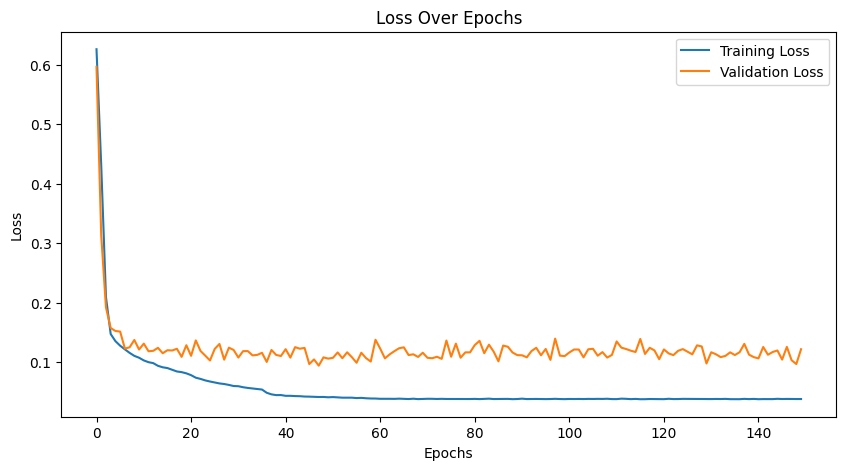

In [18]:
# Model Parameters
input_embed_size = 1024  # Original input embedding size
transformer_embed_size = 128  # Reduced embedding size for transformer
num_heads = 128  # Adjusted to fit the reduced embedding size
num_layers = 2
output_size = 1024  # Output size to match the original embedding size
dropout_rate = 0.1

# Model
model = CustomModel(input_embed_size, transformer_embed_size, output_size, dropout_rate).to(device)
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

epochs = 150


validator = Validator(model, valid_loader, device)

train_losses, valid_losses, test_loss = train_model(model, train_loader, valid_loader, test_loader, optimizer, epochs, device)
plot_losses(train_losses, valid_losses)

In [ ]:
import os

# Define the directory containing the fingerprint files
directory = '/home/chao/3dmolgen/data/train'


# Pattern to match files of interest
pattern = "_fp1024.txt"

# List to hold the names of files that do NOT contain 1024-length vectors
incorrect_length_files = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(pattern):
        # Construct the full path to the file
        filepath = os.path.join(directory, filename)
        # Open and read the file
        with open(filepath, 'r') as file:
            lines = file.readlines()  # Read all lines in the file
            content = lines[1].strip()  # Use the second line, assuming it contains the vector
            # Split the content by commas and convert to floats
            try:
                vector = [float(x) for x in content.split(',')]
                # Check if the vector length is 1024
                if len(vector) != 1024:
                    # Add to the list if the length is incorrect
                    incorrect_length_files.append(filename)
            except ValueError as e:
                print(f"Error processing {filename}: {e}")

# Print the results
if incorrect_length_files:
    print("Files with vectors not equal to 1024 in length:")
    for filename in incorrect_length_files:
        print(filename)
else:
    print("All files contain 1024-length vectors.")



In [1]:
from transformers import T5Tokenizer, T5EncoderModel
import torch

# Load the T5 tokenizer and encoder model
model_name = "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5EncoderModel.from_pretrained(model_name)

# Define the input sentence
sentence = "The molecule is an O-acylcarnitine having acetyl as the acyl substituent. It has a role as a human metabolite. It derives from an acetic acid. It is a conjugate base of an O-acetylcarnitinium."

# Tokenize the sentence and convert it to input_ids
input_ids = tokenizer.encode(sentence, return_tensors="pt", max_length=512, truncation=True)

# Generate the encoding (hidden states)
with torch.no_grad():
    encoding = model(input_ids).last_hidden_state

# Extract the 1024-length vector
sentence_vector = torch.mean(encoding, dim=1)  # Reduce the sequence dimension to 1

print(sentence_vector)




/home/chao/anaconda3/envs/EEGSDE/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.12.layer.1.layer_norm.weight', 'decoder.block.11.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.0.Sel

tensor([[-0.1073,  0.0006, -0.0436,  ...,  0.0008,  0.0665,  0.0104]])


In [10]:

# Model Parameters
input_embed_size = 1024  # Original input embedding size
transformer_embed_size = 128  # Reduced embedding size for transformer
num_heads = 128  # Adjusted to fit the reduced embedding size
num_layers = 1
output_size = 1024  # Output size to match the original embedding size
dropout_rate = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentence_vector=sentence_vector.to(device)
# Function to load the model checkpoint
def load_model(checkpoint_path, model, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    return model
def predict_fingerprint(input_vectors, model, device):
    model.eval()
    # 

    with torch.no_grad():
        # Pass only the input_ids tensor to your custom model
        outputs = model(input_vectors)
        #predictions = outputs.sigmoid()  # Apply sigmoid to the output logits
        predictions = (outputs> 0.5).int()  # Apply threshold to get binary fingerprint
    
    #return predictions.squeeze().cpu().numpy()
    return predictions
model = CustomTransformer(input_embed_size, transformer_embed_size, num_heads, num_layers, output_size, dropout_rate).to(device)

# Define optimizer
#model = CustomModel(input_embed_size, transformer_embed_size, output_size, dropout_rate).to(device)

# Rest of your code remains the same
checkpoint_path = 'model_checkpoint_GT1G.pth.tar'
#checkpoint_path = "model_checkpoint_GRU.pth.tar"

# Load the model from checkpoint
model = load_model(checkpoint_path, model, device)
predicted_fingerprint = predict_fingerprint(sentence_vector, model, device)
def write_full_tensor_to_file(tensor, filename):
    
    #Ensure tensor is on the CPU
    tensor = tensor.cpu()

    #Convert the tensor to a list of values
    tensor_values = tensor.tolist()

    # Write each element to a file, each on a new line
    with open(filename, 'w') as file:
        for value in tensor_values:
            file.write(f"{value}\n")

# Usage example
tensor_output = predicted_fingerprint
output_filename = "full_tensor_output_AE.txt"
write_full_tensor_to_file(tensor_output, output_filename)
tensor_output

tensor([[0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32)

In [9]:
from tqdm import tqdm


In [59]:
# Assuming the tanimoto_similarity function is defined as previously described
def tanimoto_similarity(vector1, vector2):
    intersection = torch.sum(vector1 * vector2)
    union = torch.sum(vector1) + torch.sum(vector2) - intersection
    # Ensure the return value is always a tensor
    similarity = intersection / union if union != 0 else torch.tensor(0.0)
    return similarity


# Initialize lists to store similarities and optionally, CIDs for reference
similarities = []
cids = []

# Assuming model is your trained model for fingerprint prediction
# Make sure the model is loaded and set to evaluation mode
model.eval()
# Assuming the updated tanimoto_similarity function is defined as previously corrected

# Function to write CID and its similarity to a text file
def write_similarity_to_file(cid, similarity, filename):
    with open(filename, 'a') as file:  # Open file in append mode
        file.write(f"{cid}: {similarity}\n")

# File to store CIDs and their similarities
output_filename = "cid_similarities_GG1G_Train.txt"
#output_filename = "test.txt"

# Ensure the file is empty before starting
open(output_filename, 'w').close()

# Iterate over the DataLoader containing your dataset
for data in tqdm(train_loader, desc="Evaluating Tanimoto Similarity"):
    description_emb = data['description_emb'].to(device)
    ground_truth_fp = data['fingerprint'].to(device)
    cid_list = data['cid']

    # Assuming predict_fingerprint is ready for batch operation
    predicted_fp = predict_fingerprint(description_emb, model, device)

    # Compute and store the Tanimoto similarity for each item in the batch
    for gt_fp, pred_fp, cid in zip(ground_truth_fp, predicted_fp, cid_list):
        similarity = tanimoto_similarity(gt_fp, pred_fp).item()  # Ensure it's a scalar
        # Write each CID and its similarity to the file
        write_similarity_to_file(cid, similarity, output_filename)



Evaluating Tanimoto Similarity: 100%|███████████████████████████████████████████████████| 25/25 [04:09<00:00,  9.97s/it]


In [14]:
def get_num_atoms_for_cid(directory, cid):
    filename = os.path.join(directory, f"{cid}.xyz")
    try:
        with open(filename, 'r') as file:
            first_line = file.readline().strip()
            num_atoms = int(first_line)
            return num_atoms
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return 'Unknown'  # Return 'Unknown' or a suitable default value if the file can't be read
directory = "/home/chao/3dmolgen/data/train"  # Update this path to where your .xyz files are stored

for data in tqdm(train_loader, desc="Writing Predicted Fingerprints"):
    description_emb = data['description_emb'].to(device)
    cid_list = data['cid']

    predicted_fp = predict_fingerprint(description_emb, model, device)

    for pred_fp, cid in zip(predicted_fp, cid_list):
        num_atoms = get_num_atoms_for_cid(directory, cid)  # Directly fetch the number of atoms for each CID
        write_predicted_fp_to_file(cid, pred_fp, num_atoms, output_filename)




Writing Predicted Fingerprints: 100%|███████████████████████████████████████████████████| 25/25 [04:19<00:00, 10.38s/it]


In [2]:
def count_molecules_with_fewer_atoms(filename, atom_threshold=29):
    count = 0  # Initialize the counter
    
    with open(filename, 'r') as file:
        for line in file:
            try:
                # Extract the number of atoms from each line
                num_atoms = int(line.strip().split("Num_atoms: ")[-1])
                # Increment the counter if the number of atoms is less than the threshold
                if num_atoms <= atom_threshold:
                    count += 1
            except ValueError as e:
                print(f"Error processing line: {line}. Exception: {e}")

    return count

# Example usage
filename = "small_mol.txt"  # Update this path to your actual file path
atom_threshold = 50
total_count = count_molecules_with_fewer_atoms(filename, atom_threshold)
print(f"Total number of molecules with fewer than {atom_threshold} atoms: {total_count}")


Total number of molecules with fewer than 50 atoms: 13280


In [17]:
import os

# Define the source directory and destination file path
source_dir = '/home/chao/3dmolgen/small_mols'
destination_file = 'small_mols_fp.txt'
destination_path = os.path.join(source_dir, destination_file)

# Ensure the destination file is empty before starting
open(destination_path, 'w').close()

# Iterate through each file in the directory
for filename in os.listdir(source_dir):
    if filename.endswith('_fp1024.txt'):
        cid = filename.split('_')[0]
        xyz_file_path = os.path.join(source_dir, f"{cid}.xyz")

        # Initialize the number of atoms variable
        num_atoms = "N/A"

        # Read the number of atoms from the .xyz file
        if os.path.isfile(xyz_file_path):
            with open(xyz_file_path, 'r') as xyz_file:
                num_atoms = xyz_file.readline().strip()

        file_path = os.path.join(source_dir, filename)
        with open(file_path, 'r') as fp_file, open(destination_path, 'a') as dest_file:
            fingerprint_data = fp_file.read().strip()
            dest_file.write(f"{fingerprint_data} num_atoms: {num_atoms}\n")

print(f"All data has been compiled into {destination_path}")


All data has been compiled into /home/chao/3dmolgen/small_mols/small_mols_fp.txt


In [16]:
import os

# Define the source directory and destination file path
source_dir = '/home/chao/3dmolgen/small_mols'
destination_file = 'small_mols_fp.txt'
destination_path = os.path.join(source_dir, destination_file)

# Ensure the destination file is empty before starting
open(destination_path, 'w').close()

# Iterate through each file in the directory
for filename in os.listdir(source_dir):
    if filename.endswith('_fp1024.txt'):
        cid = filename.split('_')[0]
        xyz_file_path = os.path.join(source_dir, f"{cid}.xyz")

        # Initialize the number of atoms variable
        num_atoms = "N/A"

        # Read the number of atoms from the .xyz file
        if os.path.isfile(xyz_file_path):
            with open(xyz_file_path, 'r') as xyz_file:
                num_atoms = xyz_file.readline().strip()

        file_path = os.path.join(source_dir, filename)
        with open(file_path, 'r') as fp_file, open(destination_path, 'a') as dest_file:
            fingerprint_data = fp_file.read().strip()
            formatted_line = f"{cid}: {fingerprint_data}, Num_atoms: {num_atoms}\n"
            dest_file.write(formatted_line)

print(f"All data has been compiled into {destination_path}")


All data has been compiled into /home/chao/3dmolgen/small_mols/small_mols_fp.txt


In [3]:
import shutil
import os

# Define the path to the input text file containing the molecule data and CIDs
input_file_path = 'small_mols.txt'  # Replace with your actual input file path

# Define the source directory where the .xyz files are stored
source_directory_path = '/home/chao/3dmolgen/data/train'

# Define the destination directory where you want to copy the .xyz files
destination_directory_path = 'small_mols'  # Replace with your actual destination directory

# Ensure the destination directory exists
os.makedirs(destination_directory_path, exist_ok=True)

# Read the content of the text file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Extract the CIDs from the lines, ignore lines with 'Num_atoms: 1'
cids = [line.split(':')[0] for line in lines if "Num_atoms: 1" not in line]

# Copy the .xyz files corresponding to the extracted CIDs
for cid in cids:
    source_file = os.path.join(source_directory_path, f"{cid.strip()}.xyz")
    destination_file = os.path.join(destination_directory_path, f"{cid.strip()}.xyz")
    
    # Check if the source file exists before copying
    if os.path.isfile(source_file):
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")
    else:
        print(f"File {source_file} does not exist.")


Copied /home/chao/3dmolgen/data/train/433294.xyz to small_mols/433294.xyz
Copied /home/chao/3dmolgen/data/train/783.xyz to small_mols/783.xyz
Copied /home/chao/3dmolgen/data/train/5460631.xyz to small_mols/5460631.xyz
Copied /home/chao/3dmolgen/data/train/24293.xyz to small_mols/24293.xyz
Copied /home/chao/3dmolgen/data/train/947.xyz to small_mols/947.xyz
Copied /home/chao/3dmolgen/data/train/10290739.xyz to small_mols/10290739.xyz
Copied /home/chao/3dmolgen/data/train/119434.xyz to small_mols/119434.xyz
Copied /home/chao/3dmolgen/data/train/522689.xyz to small_mols/522689.xyz
Copied /home/chao/3dmolgen/data/train/167583.xyz to small_mols/167583.xyz
Copied /home/chao/3dmolgen/data/train/14778.xyz to small_mols/14778.xyz
Copied /home/chao/3dmolgen/data/train/5460636.xyz to small_mols/5460636.xyz
Copied /home/chao/3dmolgen/data/train/82050.xyz to small_mols/82050.xyz
Copied /home/chao/3dmolgen/data/train/977.xyz to small_mols/977.xyz
Copied /home/chao/3dmolgen/data/train/5460626.xyz to s

Copied /home/chao/3dmolgen/data/train/50465.xyz to small_mols/50465.xyz
Copied /home/chao/3dmolgen/data/train/14057.xyz to small_mols/14057.xyz
Copied /home/chao/3dmolgen/data/train/35970.xyz to small_mols/35970.xyz
Copied /home/chao/3dmolgen/data/train/1983.xyz to small_mols/1983.xyz
Copied /home/chao/3dmolgen/data/train/11684.xyz to small_mols/11684.xyz
Copied /home/chao/3dmolgen/data/train/145815.xyz to small_mols/145815.xyz
Copied /home/chao/3dmolgen/data/train/7678.xyz to small_mols/7678.xyz
Copied /home/chao/3dmolgen/data/train/4398214.xyz to small_mols/4398214.xyz
Copied /home/chao/3dmolgen/data/train/440898.xyz to small_mols/440898.xyz
Copied /home/chao/3dmolgen/data/train/165196.xyz to small_mols/165196.xyz
Copied /home/chao/3dmolgen/data/train/5315892.xyz to small_mols/5315892.xyz
Copied /home/chao/3dmolgen/data/train/19910.xyz to small_mols/19910.xyz
Copied /home/chao/3dmolgen/data/train/656883.xyz to small_mols/656883.xyz
Copied /home/chao/3dmolgen/data/train/6326993.xyz to

Copied /home/chao/3dmolgen/data/train/7567127.xyz to small_mols/7567127.xyz
Copied /home/chao/3dmolgen/data/train/186004.xyz to small_mols/186004.xyz
Copied /home/chao/3dmolgen/data/train/8094.xyz to small_mols/8094.xyz
Copied /home/chao/3dmolgen/data/train/53477624.xyz to small_mols/53477624.xyz
Copied /home/chao/3dmolgen/data/train/135409400.xyz to small_mols/135409400.xyz
Copied /home/chao/3dmolgen/data/train/1137.xyz to small_mols/1137.xyz
Copied /home/chao/3dmolgen/data/train/3080627.xyz to small_mols/3080627.xyz
Copied /home/chao/3dmolgen/data/train/50937014.xyz to small_mols/50937014.xyz
Copied /home/chao/3dmolgen/data/train/21327.xyz to small_mols/21327.xyz
Copied /home/chao/3dmolgen/data/train/439554.xyz to small_mols/439554.xyz
Copied /home/chao/3dmolgen/data/train/2723716.xyz to small_mols/2723716.xyz
Copied /home/chao/3dmolgen/data/train/1826.xyz to small_mols/1826.xyz
Copied /home/chao/3dmolgen/data/train/91462.xyz to small_mols/91462.xyz
Copied /home/chao/3dmolgen/data/tr

Copied /home/chao/3dmolgen/data/train/49867371.xyz to small_mols/49867371.xyz
Copied /home/chao/3dmolgen/data/train/25060473.xyz to small_mols/25060473.xyz
Copied /home/chao/3dmolgen/data/train/3034164.xyz to small_mols/3034164.xyz
Copied /home/chao/3dmolgen/data/train/676158.xyz to small_mols/676158.xyz
Copied /home/chao/3dmolgen/data/train/82170.xyz to small_mols/82170.xyz
Copied /home/chao/3dmolgen/data/train/65057.xyz to small_mols/65057.xyz
Copied /home/chao/3dmolgen/data/train/122136.xyz to small_mols/122136.xyz
Copied /home/chao/3dmolgen/data/train/11513983.xyz to small_mols/11513983.xyz
Copied /home/chao/3dmolgen/data/train/443161.xyz to small_mols/443161.xyz
Copied /home/chao/3dmolgen/data/train/5366876.xyz to small_mols/5366876.xyz
Copied /home/chao/3dmolgen/data/train/19881764.xyz to small_mols/19881764.xyz
Copied /home/chao/3dmolgen/data/train/5281553.xyz to small_mols/5281553.xyz
Copied /home/chao/3dmolgen/data/train/120282.xyz to small_mols/120282.xyz
Copied /home/chao/3d

Copied /home/chao/3dmolgen/data/train/68482.xyz to small_mols/68482.xyz
Copied /home/chao/3dmolgen/data/train/1712087.xyz to small_mols/1712087.xyz
Copied /home/chao/3dmolgen/data/train/8189.xyz to small_mols/8189.xyz
Copied /home/chao/3dmolgen/data/train/84265.xyz to small_mols/84265.xyz
Copied /home/chao/3dmolgen/data/train/440281.xyz to small_mols/440281.xyz
Copied /home/chao/3dmolgen/data/train/546887.xyz to small_mols/546887.xyz
Copied /home/chao/3dmolgen/data/train/10932172.xyz to small_mols/10932172.xyz
Copied /home/chao/3dmolgen/data/train/1549016.xyz to small_mols/1549016.xyz
Copied /home/chao/3dmolgen/data/train/5897.xyz to small_mols/5897.xyz
Copied /home/chao/3dmolgen/data/train/3015486.xyz to small_mols/3015486.xyz
Copied /home/chao/3dmolgen/data/train/60712.xyz to small_mols/60712.xyz
Copied /home/chao/3dmolgen/data/train/91493.xyz to small_mols/91493.xyz
Copied /home/chao/3dmolgen/data/train/86289563.xyz to small_mols/86289563.xyz
Copied /home/chao/3dmolgen/data/train/44

Copied /home/chao/3dmolgen/data/train/129900407.xyz to small_mols/129900407.xyz
Copied /home/chao/3dmolgen/data/train/49792011.xyz to small_mols/49792011.xyz
Copied /home/chao/3dmolgen/data/train/443902.xyz to small_mols/443902.xyz
Copied /home/chao/3dmolgen/data/train/11044279.xyz to small_mols/11044279.xyz
Copied /home/chao/3dmolgen/data/train/23241229.xyz to small_mols/23241229.xyz
Copied /home/chao/3dmolgen/data/train/6993123.xyz to small_mols/6993123.xyz
Copied /home/chao/3dmolgen/data/train/441964.xyz to small_mols/441964.xyz
Copied /home/chao/3dmolgen/data/train/5363240.xyz to small_mols/5363240.xyz
Copied /home/chao/3dmolgen/data/train/92042786.xyz to small_mols/92042786.xyz
Copied /home/chao/3dmolgen/data/train/580944.xyz to small_mols/580944.xyz
Copied /home/chao/3dmolgen/data/train/146672233.xyz to small_mols/146672233.xyz
Copied /home/chao/3dmolgen/data/train/5147705.xyz to small_mols/5147705.xyz
Copied /home/chao/3dmolgen/data/train/643.xyz to small_mols/643.xyz
Copied /ho

Copied /home/chao/3dmolgen/data/train/3085369.xyz to small_mols/3085369.xyz
Copied /home/chao/3dmolgen/data/train/439538.xyz to small_mols/439538.xyz
Copied /home/chao/3dmolgen/data/train/192813.xyz to small_mols/192813.xyz
Copied /home/chao/3dmolgen/data/train/23663963.xyz to small_mols/23663963.xyz
Copied /home/chao/3dmolgen/data/train/10214674.xyz to small_mols/10214674.xyz
Copied /home/chao/3dmolgen/data/train/86289405.xyz to small_mols/86289405.xyz
Copied /home/chao/3dmolgen/data/train/6327657.xyz to small_mols/6327657.xyz
Copied /home/chao/3dmolgen/data/train/23259347.xyz to small_mols/23259347.xyz
Copied /home/chao/3dmolgen/data/train/135499974.xyz to small_mols/135499974.xyz
Copied /home/chao/3dmolgen/data/train/135475930.xyz to small_mols/135475930.xyz
Copied /home/chao/3dmolgen/data/train/24796647.xyz to small_mols/24796647.xyz
Copied /home/chao/3dmolgen/data/train/92418.xyz to small_mols/92418.xyz
Copied /home/chao/3dmolgen/data/train/24796778.xyz to small_mols/24796778.xyz


Copied /home/chao/3dmolgen/data/train/11629002.xyz to small_mols/11629002.xyz
Copied /home/chao/3dmolgen/data/train/5282242.xyz to small_mols/5282242.xyz
Copied /home/chao/3dmolgen/data/train/6305587.xyz to small_mols/6305587.xyz
Copied /home/chao/3dmolgen/data/train/193686.xyz to small_mols/193686.xyz
Copied /home/chao/3dmolgen/data/train/11302345.xyz to small_mols/11302345.xyz
Copied /home/chao/3dmolgen/data/train/7408102.xyz to small_mols/7408102.xyz
Copied /home/chao/3dmolgen/data/train/25245604.xyz to small_mols/25245604.xyz
Copied /home/chao/3dmolgen/data/train/10472401.xyz to small_mols/10472401.xyz
Copied /home/chao/3dmolgen/data/train/113125.xyz to small_mols/113125.xyz
Copied /home/chao/3dmolgen/data/train/136168052.xyz to small_mols/136168052.xyz
Copied /home/chao/3dmolgen/data/train/440758.xyz to small_mols/440758.xyz
Copied /home/chao/3dmolgen/data/train/14237660.xyz to small_mols/14237660.xyz
Copied /home/chao/3dmolgen/data/train/4612.xyz to small_mols/4612.xyz
Copied /ho

Copied /home/chao/3dmolgen/data/train/9930620.xyz to small_mols/9930620.xyz
Copied /home/chao/3dmolgen/data/train/71298169.xyz to small_mols/71298169.xyz
Copied /home/chao/3dmolgen/data/train/10617107.xyz to small_mols/10617107.xyz
Copied /home/chao/3dmolgen/data/train/9819401.xyz to small_mols/9819401.xyz
Copied /home/chao/3dmolgen/data/train/135398736.xyz to small_mols/135398736.xyz
Copied /home/chao/3dmolgen/data/train/91862215.xyz to small_mols/91862215.xyz
Copied /home/chao/3dmolgen/data/train/7021820.xyz to small_mols/7021820.xyz
Copied /home/chao/3dmolgen/data/train/6077.xyz to small_mols/6077.xyz
Copied /home/chao/3dmolgen/data/train/91851217.xyz to small_mols/91851217.xyz
Copied /home/chao/3dmolgen/data/train/18652485.xyz to small_mols/18652485.xyz
Copied /home/chao/3dmolgen/data/train/6454902.xyz to small_mols/6454902.xyz
Copied /home/chao/3dmolgen/data/train/71771808.xyz to small_mols/71771808.xyz
Copied /home/chao/3dmolgen/data/train/91850082.xyz to small_mols/91850082.xyz


Copied /home/chao/3dmolgen/data/train/56206.xyz to small_mols/56206.xyz
Copied /home/chao/3dmolgen/data/train/25766071.xyz to small_mols/25766071.xyz
Copied /home/chao/3dmolgen/data/train/71736.xyz to small_mols/71736.xyz
Copied /home/chao/3dmolgen/data/train/14427336.xyz to small_mols/14427336.xyz
Copied /home/chao/3dmolgen/data/train/124079391.xyz to small_mols/124079391.xyz
Copied /home/chao/3dmolgen/data/train/138824.xyz to small_mols/138824.xyz
Copied /home/chao/3dmolgen/data/train/56927788.xyz to small_mols/56927788.xyz
Copied /home/chao/3dmolgen/data/train/14029652.xyz to small_mols/14029652.xyz
Copied /home/chao/3dmolgen/data/train/1548943.xyz to small_mols/1548943.xyz
Copied /home/chao/3dmolgen/data/train/71464663.xyz to small_mols/71464663.xyz
Copied /home/chao/3dmolgen/data/train/40561833.xyz to small_mols/40561833.xyz
Copied /home/chao/3dmolgen/data/train/44229199.xyz to small_mols/44229199.xyz
Copied /home/chao/3dmolgen/data/train/656773.xyz to small_mols/656773.xyz
Copied

In [1]:
def count_total_molecules(filename):
    with open(filename, 'r') as file:
        total_count = sum(1 for _ in file)
    return total_count

# Example usage
filename = "small_mols.txt"  # Update this path to your actual file path
total_molecules = count_total_molecules(filename)
print(f"Total number of molecules in the file: {total_molecules}")


Total number of molecules in the file: 10969


In [5]:

def sort_and_write_small_molecules(filename, output_filename, atom_threshold=29):
    small_molecules = []  # List to store lines corresponding to small molecules
    
    with open(filename, 'r') as file:
        for line in file:
            try:
                num_atoms = int(line.strip().split("Num_atoms: ")[-1])
                if num_atoms <= atom_threshold:
                    small_molecules.append((num_atoms, line))
            except ValueError as e:
                print(f"Error processing line: {line}. Exception: {e}")

    # Sort the list of small molecules by the number of atoms
    small_molecules.sort(key=lambda x: x[0])

    # Write the sorted small molecules into the new file
    with open(output_filename, 'w') as output_file:
        for _, molecule_line in small_molecules:
            output_file.write(molecule_line)

# Example usage
filename = "cid_predicted_fingerprints.txt"  # Update this path to your actual file path
output_filename = "small_mol.txt"
atom_threshold = 50
sort_and_write_small_molecules(filename, output_filename, atom_threshold)
print(f"Small molecules with fewer than {atom_threshold} atoms have been sorted and written to {output_filename}.")


Small molecules with fewer than 50 atoms have been sorted and written to small_mol.txt.


In [12]:
# Define the path to the original text file and the output file
input_file_path = 'small_mol.txt'  # Replace with the path to your text file
output_file_path = 'small_mols.txt'  # Replace with the path to your desired output file

# Read the content of the original text file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Filter out lines that contain 'Num_atoms: 1'
filtered_lines = [line for line in lines if "Num_atoms: 1" not in line]

# Save the filtered lines to the new text file
with open(output_file_path, 'w') as file:
    file.writelines(filtered_lines)

print(f"The filtered content has been saved to {output_file_path}")



The filtered content has been saved to small_mols.txt


In [27]:
def remove_repetitive_cids_and_rewrite(filename):
    seen_cids = set()  # Set to store CIDs that have been encountered
    lines_to_keep = []  # List to store lines that will be written back to the file

    with open(filename, 'r') as file:
        for line in file:
            cid = line.split(":")[0].strip()  # Extract CID from the line
            if cid not in seen_cids:
                seen_cids.add(cid)  # Add new CID to the set of seen CIDs
                lines_to_keep.append(line)  # Add line to the list of lines to keep

    # Rewrite the file with only the lines to keep
    with open(filename, 'w') as file:
        file.writelines(lines_to_keep)

    print(f"File '{filename}' has been rewritten with unique CIDs.")

# Example usage
filename = "small_mol.txt"  # Update this path to your actual file path
remove_repetitive_cids_and_rewrite(filename)


File 'small_mol.txt' has been rewritten with unique CIDs.


In [1]:
def find_repetitive_cids(filename):
    seen_cids = set()  # Set to store CIDs that have been encountered
    repetitive_cids = set()  # Set to store CIDs that appear more than once

    with open(filename, 'r') as file:
        for line in file:
            cid = line.split(":")[0].strip()  # Extract CID from the line
            if cid in seen_cids:
                repetitive_cids.add(cid)  # If CID has been seen before, add it to the repetitive CIDs set
            else:
                seen_cids.add(cid)  # Otherwise, add it to the set of seen CIDs

    return repetitive_cids

# Example usage
filename = "small_mols.txt"  # Update this path to your actual file path
repetitive_cids = find_repetitive_cids(filename)
if repetitive_cids:
    print(f"Repetitive CIDs found: {repetitive_cids}")
else:
    print("No repetitive CIDs found.")


No repetitive CIDs found.


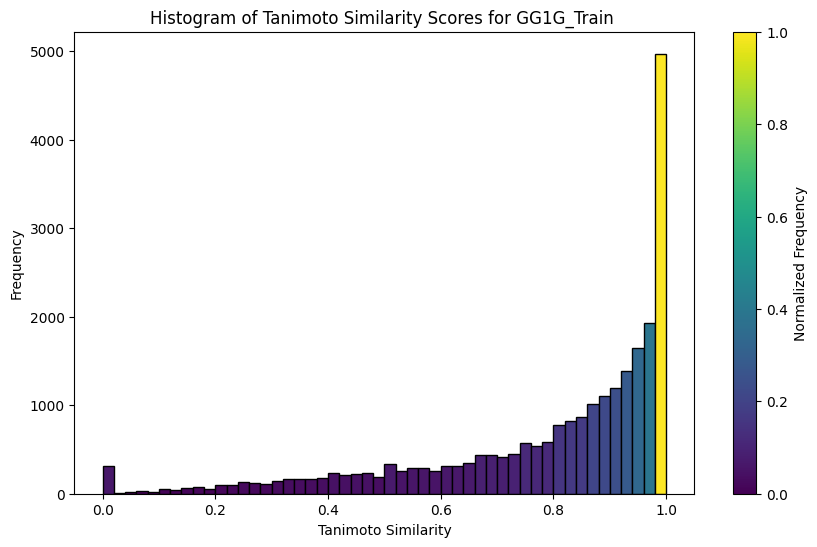

In [60]:
def read_similarity_scores(filename):
    similarities = []
    with open(filename, 'r') as file:
        for line in file:
            # Assuming the line format is "CID: similarity\n"
            parts = line.strip().split(': ')
            if len(parts) == 2:
                _, similarity = parts
                similarities.append(float(similarity))
    return similarities

# Read the similarity scores from the file
similarity_scores = read_similarity_scores("cid_similarities_GG1G_Train.txt")
import matplotlib.pyplot as plt
import numpy as np

# Assuming similarity_scores contains your Tanimoto similarity scores
similarity_scores = np.array(similarity_scores)  # Convert list of scores to numpy array for easier manipulation

# Calculate histogram data
n_bins = 50
counts, bin_edges = np.histogram(similarity_scores, bins=n_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Normalize counts to get a range suitable for color mapping
norm_counts = counts / counts.max()

# Create a colormap
cmap = plt.cm.viridis  # You can choose any available colormap

plt.figure(figsize=(10, 6))

# Plot each bar individually
for count, bin_center, norm_count in zip(counts, bin_centers, norm_counts):
    plt.bar(bin_center, count, width=(bin_edges[1] - bin_edges[0]), color=cmap(norm_count), edgecolor='black')

plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Normalized Frequency')
plt.title('Histogram of Tanimoto Similarity Scores for GG1G_Train ')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')
plt.show()




In [9]:
mol1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mol2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

import torch
v1= torch.tensor(mol1,dtype=torch.float)
v2= torch.tensor(mol2,dtype=torch.float)
def tanimoto_similarity(vector1, vector2):
    intersection = torch.sum(vector1 * vector2)
    union = torch.sum(vector1) + torch.sum(vector2) - intersection
    return intersection / union if union != 0 else 0

# Example usage

similarity = tanimoto_similarity(v1, v2)
print(similarity)


tensor(0.9412)


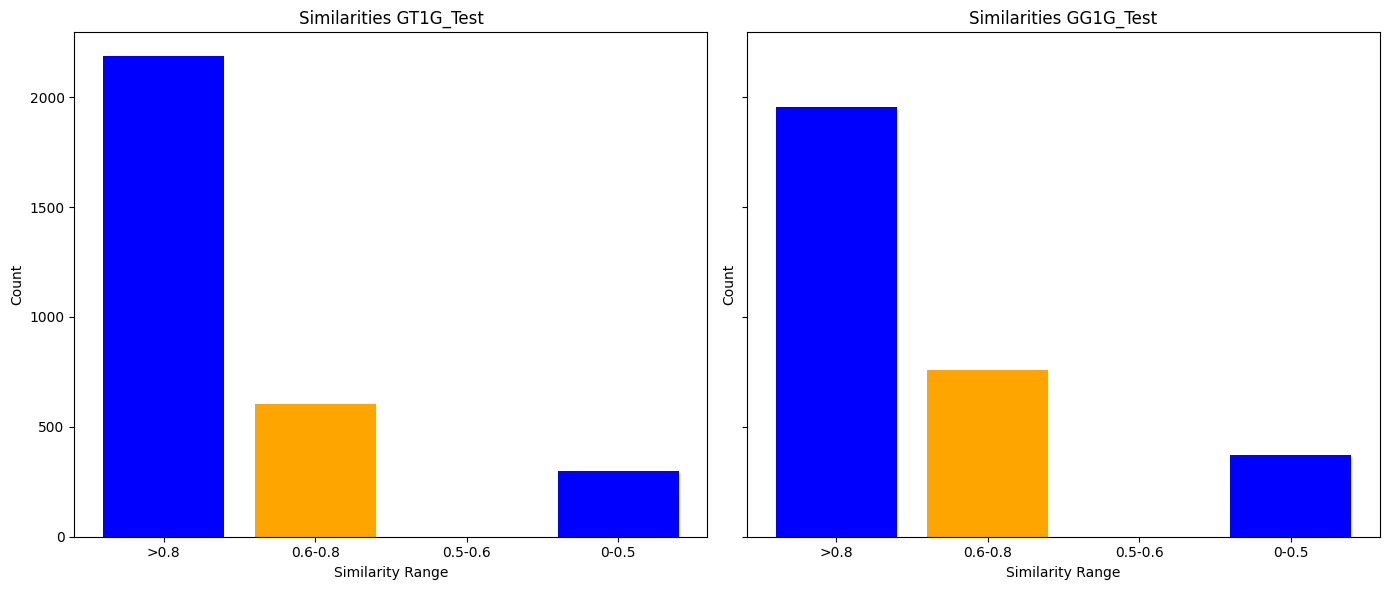

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and correct the dataset
def load_and_correct_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None, names=['Data'])
    df[['CID', 'Similarity']] = df['Data'].str.split(':', expand=True)[[0, 1]]
    df['CID'] = pd.to_numeric(df['CID'], errors='coerce')
    df['Similarity'] = pd.to_numeric(df['Similarity'], errors='coerce')
    df.drop(columns=['Data'], inplace=True)
    return df

# Categorize similarities
def categorize_similarities(df):
    categories = {
        '>0.8': 0,
        '0.6-0.8': 0,
        '0.5-0.6': 0,
        '0-0.5': 0
    }
    for similarity in df['Similarity']:
        if similarity > 0.8:
            categories['>0.8'] += 1
        elif 0.6 <= similarity <= 0.8:
            categories['0.6-0.8'] += 1
        elif 0.5 <= similarity <= 0.6:
            categories['0.6-0.8'] += 1
        elif 0 <= similarity <= 0.5:
            categories['0-0.5'] += 1
    return categories

# Load the datasets
gtg_df = load_and_correct_data('cid_similarities_GT1G.txt')
ggg_df = load_and_correct_data('cid_similarities_GG1G.txt')

# Categorize the molecules in each dataset
gtg_categories = categorize_similarities(gtg_df)
ggg_categories = categorize_similarities(ggg_df)

# Plotting the categorized data
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
titles = ['Similarities GT1G_Test', 'Similarities GG1G_Test']

for i, categories in enumerate([gtg_categories, ggg_categories]):
    ax[i].bar(categories.keys(), categories.values(), color=['blue', 'orange', 'green'])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Similarity Range')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [65]:
# The document contains values after the ":" which need to be averaged. We will read the document, extract these values,
# and calculate the average.

# Open the file and read its lines
with open("cid_similarities_GG1G_Train.txt", "r") as file:
    lines = file.readlines()

# Extract the similarity values
similarity_values = [float(line.split(": ")[1]) for line in lines]

# Calculate the average similarity
average_similarity = sum(similarity_values) / len(similarity_values)

average_similarity


0.7920277463087457

In [66]:
# The document contains values after the ":" which need to be averaged. We will read the document, extract these values,
# and calculate the average.

# Open the file and read its lines
with open("cid_similarities_GT1G_Train.txt", "r") as file:
    lines = file.readlines()

# Extract the similarity values
similarity_values = [float(line.split(": ")[1]) for line in lines]

# Calculate the average similarity
average_similarity = sum(similarity_values) / len(similarity_values)

average_similarity

0.8263427013451392

In [67]:
# The document contains values after the ":" which need to be averaged. We will read the document, extract these values,
# and calculate the average.

# Open the file and read its lines
with open("cid_similarities_GT1G.txt", "r") as file:
    lines = file.readlines()

# Extract the similarity values
similarity_values = [float(line.split(": ")[1]) for line in lines]

# Calculate the average similarity
average_similarity = sum(similarity_values) / len(similarity_values)

average_similarity

0.826265782343966

In [69]:
# The document contains values after the ":" which need to be averaged. We will read the document, extract these values,
# and calculate the average.

# Open the file and read its lines
with open("cid_similarities_GG1G.txt", "r") as file:
    lines = file.readlines()

# Extract the similarity values
similarity_values = [float(line.split(": ")[1]) for line in lines]

# Calculate the average similarity
average_similarity = sum(similarity_values) / len(similarity_values)

average_similarity

0.793977437432953